<font size=6><b>**Тестовое от Работа.ру**</b></font>
    
<font size=6><b>**Бинарная классификации откликов**</b></font>

<font size=4><b>Часть 1. Постановка задачи, обзор и анализ данных.</b></font>


***

# Постановка задачи

**Заказчик**  
Работа.ру

**Цель**  
Автоматизировать труд рекрутеров в части просмотра и оценки резюме, что позволит существенно сэкономить ресурсы по подбору персонала.

**Задачи**  

1. *Проанализировать датасет и провести обработку данных.*
1. Сгенерировать новые признаки.
1. На основе результатов предыдущего шага определить модель для предсказания факта приглашения работодателем откликнувшегося соискателя на собеседование.

**Исходные данные**  

Данные представлены в виде датасета с основными параметрами вакансий\резюме (название, описание, требования по опыту работы, графику работы, знанию иностранных языков, перечень навыков и т. д.). 
Вакансии и резюме представлены парами.  
Целевая переменная первой задачи – откликнется (1) или не откликнется (0) соискатель с данным резюме на данную вакансию.  
Целевая переменная второй задачи – пригласит (1) или не пригласит (0) работодатель откликнувшегося соискателя на собеседование.


# Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта.

In [1]:
import datetime
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import re
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
try:
    import phik
except Exception:
    ! pip install phik
    import phik

In [3]:
# автоформатирование Jupyter lab
try:
    %load_ext lab_black
except:
    None

In [4]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# отображение таблиц без ограничения на количество столбцов
pd.set_option("display.max_columns", None)

Загрузим сами данные.

In [6]:
# Colab
#!pip install --upgrade --no-cache-dir gdown
#!gdown 11TxYKx58dwbJv57xX2EY5mSecZFz4oX3
# df = pd.read_csv("/content/vacancy_resume_data.csv")

# Local
df = pd.read_csv("vacancy_resume_data.csv")

# Обзор данных

Проведем первичный обзор данных для формулирования плана проведения EDA.

Вызовем первые 5 строк, общую информацию о таблице, а также количество дубликатов.



In [7]:
df.head()

,resume_id,vacancy_id,birth_date,resume_position,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_custom_position,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_description,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_operating_schedule_comment,vacancy_offer_experience_year_id,target_task_1,target_task_2
0,28826595,43881267,1996-01-01,Корректор,20000.0,1.0,False,False,4.0,False,False,81.0,0.0,3.0,Менеджер-переводчик,1,30000,40000.0,<strong>Требования:</strong><br />\r\n<ul>\r\n...,4,-100.0,927123,False,1,NaN,0.0,0,1
1,29196877,43601457,1973-01-01,комплектовщик,50.0,86.0,False,True,6.0,False,False,72.0,NaN,282.0,Комплектовщик,7,50000,NaN,В связи с расширением распределительного центр...,0,NaN,1583114,False,16,NaN,NaN,0,1
2,25778536,43454765,1970-02-23,Шеф повар,NaN,1.0,False,True,4.0,False,True,87.0,5.0,3.0,Шеф-повар,1,40000,NaN,<strong>Торговая сеть &laquo;Перекрёсток&raquo...,0,0.0,1141124,False,1,NaN,NaN,0,1
3,28782671,43833295,1984-01-01,Дизайнер,35000.0,1.0,False,True,4.0,False,True,88.0,NaN,156.0,Дизайнер интерьера,6,-1,-1.0,<strong>Обязанности:</strong><br />\r\nНужно п...,0,1.0,1765004,False,57,NaN,NaN,0,1
4,23624154,42093862,2003-10-17,Помощник юриста/Младший юрист,45000.0,57.0,False,False,4.0,False,True,85.0,NaN,209.0,Администратор выходного дня,1,-1,-1.0,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,0,-100.0,1739407,False,1,NaN,NaN,0,1


In [8]:
def first_look(df):
    # print(df.head())
    print(df.info())
    print(f"Количество дубликатов: {df.duplicated().sum()}")

In [9]:
first_look(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298072 entries, 0 to 298071
Data columns (total 28 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   resume_id                            298072 non-null  int64  
 1   vacancy_id                           298072 non-null  int64  
 2   birth_date                           298024 non-null  object 
 3   resume_position                      298071 non-null  object 
 4   resume_salary_from                   227772 non-null  float64
 5   resume_city_id                       298072 non-null  float64
 6   resume_city_search_job               298072 non-null  bool   
 7   resume_is_leaving                    298072 non-null  bool   
 8   resume_offer_education_id            216561 non-null  float64
 9   resume_is_foreign_language           298072 non-null  bool   
 10  resume_is_upload_photo               298072 non-null  bool   
 11  percentage_of

По полученной информации можно сделать следующие первичные выводы.  
- Датасет содержит почти 300 000 объектов с информацией о соискателе (признаки 0, 2-13), о вакансии (признаки 1, 14-25) и разметку на две задачи (признаки 26 и 27).  
- Во многих столбцах содержаться пропуски, решение о стратегии их обработки примем в ходе EDA.  
- В целом тип хранения данных соответствует ожидаемому. 
Исключение - признак `birth_date` содержит даты, а тип хранения - object.
Это не позволяет использовать и обрабатывать дату, в связи с чем потребуется изменение типа на datetime и, возможно, перевод самой даты в возраст.
- Признаки `resume_position`, `vacancy_custom_position`, `vacancy_description`, `vacancy_operating_schedule_comment` содержат тексты.
Потребуется их анализ на наличие неявных дубликатов, лемматизация и кодирование. 
- В датасете нет явных дубликатов, однако могут присутствовать неявные. 
К последним могут относиться объекты с одинаковым мэтчем вакансия-резюме, но разными остальными параметрами.
- Признаки `resume_id` и `vacancy_id`, скорее всего, не несут смысловой нагрузки и могут быть исключены.

Согласно полученному результату представляется целесообразным проведение EDA в следующей последовательности.
1. Анализ распределения целевых признаков.
1. Анализ и обработка категориальных признаков с ID и их влияния на целевые.
1. Анализ и обработка признаков с непрерывными значениями.
1. Анализ и обработка признаков с бинарными значениями.
1. Анализ и обработка признаков с текстами.
1. Анализ коэффициента корреляции phik между признаками.

Обработку признаков будем проводить с учетом моделирования задачи при помощи библиотеки Catboost.

# Анализ данных

## Целевые признаки

Начнем с рассмотрения распределений целевых признаков

In [10]:
y_1 = ["target_task_1"]
y_2 = ["target_task_2"]
y_s = ["target_task_1", "target_task_2"]

Баланс классов target_task_1:  0.503
Баланс классов target_task_2:  0.844


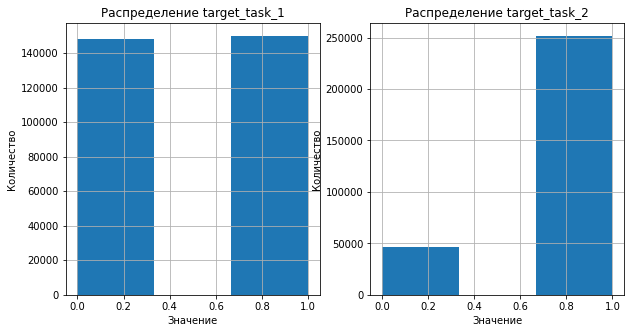

In [11]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    df[y_s[i]].hist(ax=axs[i], bins=3)
    axs[i].set_title("Распределение " + y_s[i])
    axs[i].set_xlabel("Значение")
    axs[i].set_ylabel("Количество")
    print(f"Баланс классов {y_s[i]}: ", round(df[y_s[i]].mean(), 3))

plt.show()

Для первой задачи классы можно считать сбалансированными.
Другими словами, соискатели откликаются на каждую вторую вакансию.
  
В то же время, во втором целевом признаке позитивных значений (1) почти в 4 раза больше негативных (0). Другими словами, вероятность приглашения соискателя равна 84%.
Такое значение говорит о том, что на первом этапе задачи сервис подбирает для соискателей такие вакансии, на которые их с высокой вероятностью пригласят.

Построим распределение второго признака с учетом значения первого.

Баланс классов target_task_2 при target_task_1 = 0:  0.797
Баланс классов target_task_2 при target_task_1 = 1:  0.89


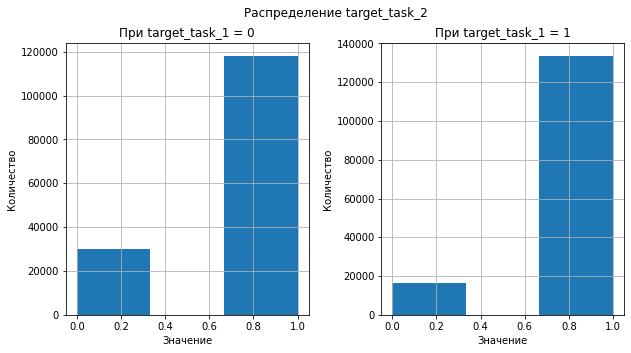

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Распределение target_task_2")

for i in range(2):
    df[df["target_task_1"] == i][y_2].hist(ax=axs[i], bins=3)
    axs[i].set_title(f"При target_task_1 = {i}")
    axs[i].set_xlabel("Значение")
    axs[i].set_ylabel("Количество")
    print(
        f"Баланс классов target_task_2 при target_task_1 = {i}: ",
        round(df[df["target_task_1"] == i][y_s[1]].mean(), 3),
    )

plt.show()

Баланс классов близок к полученному без срезов по значению признака `target_task_1`.
При этом, распределение на левом рисунке не соответствует условию задачи так как работодатель может позвать на собеседование только откликнувшегося на вакансию соискателя.
В этой связи, объекты, соответствующие указанному случаю должны быть исключены из рассмотрения при построении модели и оценке ее качества.

Сохраним срез датасета по целевой переменной `target_task_1 = 1` в отдельную переменную. 

In [13]:
df_task_2 = df[df["target_task_1"] == 1]

Посмотрим распределение признаков по строкам датасета.

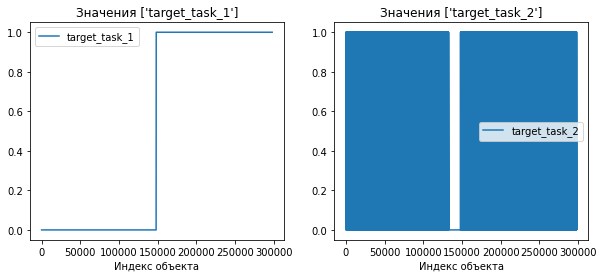

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    df.plot(y=[y_s[i]], ax=axs[i])
    axs[i].set_title(f"Значения {[y_s[i]]}")
    axs[i].set_xlabel("Индекс объекта")

plt.show()

Датасет сформирован таким образом, что вся первая его половина для первой задачиимеет значение `0`, а вторая - `1`.
В то же время, для второй задачи значения чередуются, за исключением интервала около строк 140 000 - 150 000.

Подобные графики могут свидетельствовать о специальной подготовке датасета.

## Признаки ID

### Резюме и вакансии

Посмотрим количество уникальных резюме и вакансий в отношении к общей длине датасета.

In [14]:
def uniq_printer(feature, name):
    value = df[feature].nunique()
    percent = round(value / len(df) * 100, 2)
    print(f"Количество уникальных {name}: {value} ({percent}%)")

In [15]:
lenght_init = len(df)

uniq_printer("resume_id", "резюме")
uniq_printer("vacancy_id", "вакансий")

Количество уникальных резюме: 240107 (80.55%)
Количество уникальных вакансий: 158374 (53.13%)


Проверим, есть ли дубликаты в датасете, если исключить из рассмотрения рассматриваемые столбцы.

In [16]:
df.drop(["resume_id", "vacancy_id"], axis=1).duplicated().sum()

158

В датасете 158 повторений без учета id резюме и вакансии.
Это соответствует случаю, когда пользователь создает несколько одинаковых резюме, например, с целью поднятия их в поиске и компании делают то же самое.
Такие объекты необходимо удалить во избежание утечки данных при моделировании.

In [17]:
df = df.drop_duplicates(subset=df.drop(["resume_id", "vacancy_id"], axis=1).columns)
df = df.reset_index(drop=True)

df_task_2 = df[df["target_task_1"] == 1]

Посмотрим распределение целевых признаков по рассматриваемым признакам.

In [18]:
def graphplotter(df, feature, target, stage, kind=False):
    t = df.groupby(by=feature)[target].mean().sort_values(ascending=False).reset_index()
    t[feature] = t[feature].astype("str")
    t = t.set_index(feature)

    if kind:
        t.plot(kind=kind, figsize=(15, 3), legend=False, fontsize=8)
    else:
        t.plot(figsize=(15, 3), legend=False)

    plt.xlabel(f"id")
    plt.title(
        f"""Количество {stage} на один {feature}. 
    Среднее: {round(df.groupby(by=feature)[target].mean().mean() * 100, 1)}%"""
    )

    plt.show()

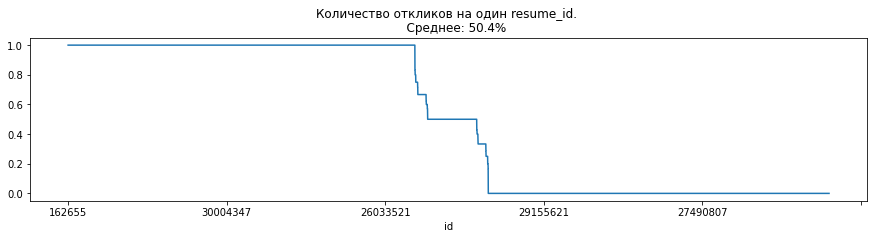

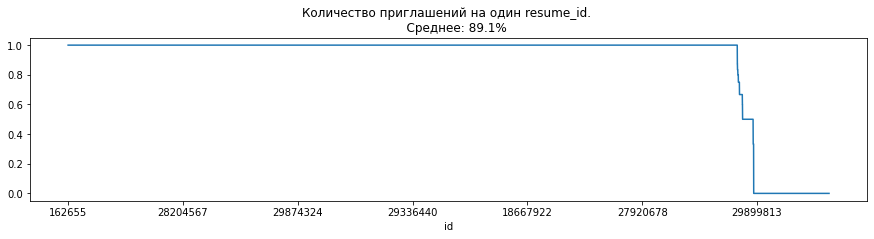

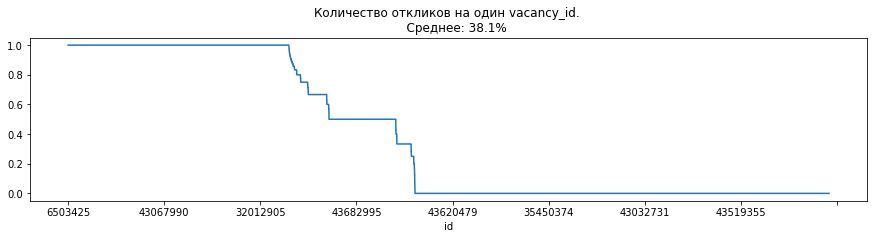

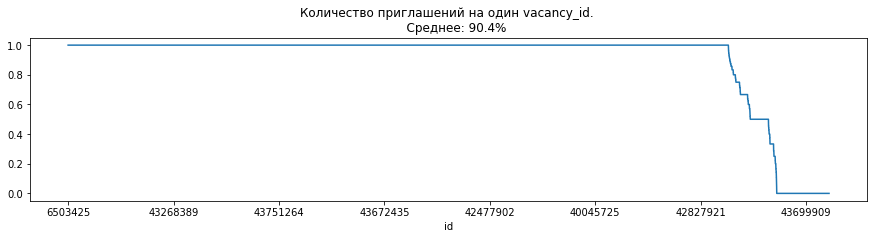

In [19]:
graphplotter(df, "resume_id", "target_task_1", "откликов")

graphplotter(df_task_2, "resume_id", "target_task_2", "приглашений")

graphplotter(df, "vacancy_id", "target_task_1", "откликов")

graphplotter(df_task_2, "vacancy_id", "target_task_2", "приглашений")

Из графиков можно сделать следующие выводы:  
1. Есть резюме, которые соискатели отправляют на каждую совпавшую вакансию. 
При этом есть и такие резюме, которые ни разу не были отправлены. 
Процентное соотношение таких резюме - примерно 50%.
1. Аналогичная ситуация с вакансиями, но процентное соотношение ниже и составляет 38%.
Такая, на первый взгляд, несогласованность значений объясняется различным количеством уникальных резюме и вакансий в датасете.
2. В случае отклика работодатели приглашают почти 90% соискателей.
Полученное значение соответствует приведенному выше распределению по целевой переменной в целом. 

ID резюме и вакансий должны обладать уникальными значениями и не должны влиять на качество работы сервиса.
При моделировании проверим эту гипотезу. 

### Город

Посмотрим количество уникальных городов в отношении к общей длине датасета.

In [20]:
uniq_printer("resume_city_id", "городов в резюме")
uniq_printer("vacancy_city_id", "городов в вакансиях")

Количество уникальных городов в резюме: 93 (0.03%)
Количество уникальных городов в вакансиях: 67 (0.02%)


Интересный факт, что в резюме и вакансиях используется различное количество городов.
Это может объясняться тем, что в резюме пользователи указывают пригороды, а для размещения вакансий наиболее характерны более крупные города.

Построим гистограмму по индексам городов в резюме и вакансиях

In [21]:
def barplotter(feature, figsize):
    resume_unique_id = pd.DataFrame(df[f"resume_{feature}_id"].value_counts())
    vacancy_unique_id = pd.DataFrame(df[f"vacancy_{feature}_id"].value_counts())

    t = resume_unique_id.join(vacancy_unique_id, how="outer")

    t.plot(kind="bar", figsize=figsize, logy=True)
    plt.xlabel(f"{feature}_id")
    plt.ylabel("Количество объектов")

    plt.show()

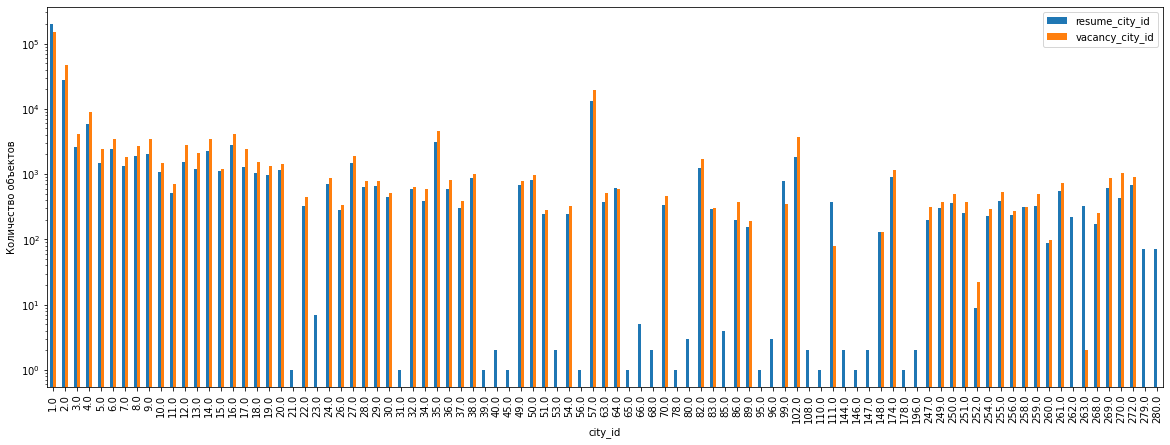

In [22]:
barplotter("city", (20, 7))

Из графика хорошо видно, что нет такого города, где была бы размещена вакансия, а резюме в нем не было бы.
Кроме того, код города не соответствует кодам ГИБДД или ОКАТО регионов.
Например, 77 регона (Москва) нет совсем, а в 01 регионе (Адыгея) больше всего вакансий и резюме.

Несмотря на логарифмический масштаб гистограммы, видно, что количество резюме и вакансий в одном городе соизмеримы (имеют один порядок).
Исключение - город №263, в котором количество резюме на 2 порядка больше.
Такое распределение характерно для крупного пригорода мегаполиса, например, Гатчина в ЛО или Мытищи в МО.

Исправим тип хранения данных в признаке `resume_city_id` и посмотрим распределения целевых признаков по городам.

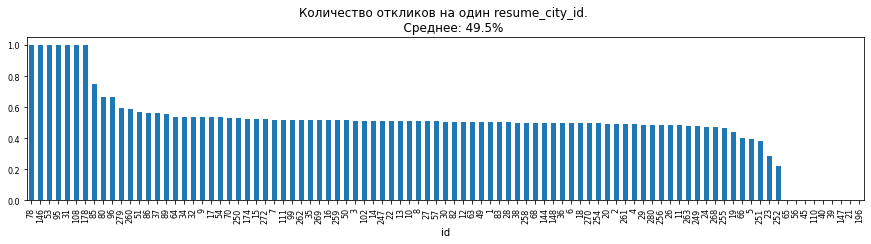

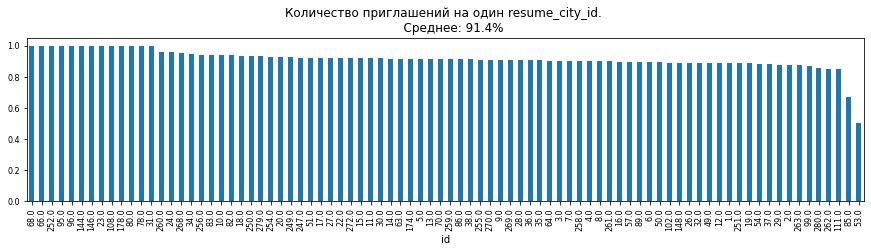

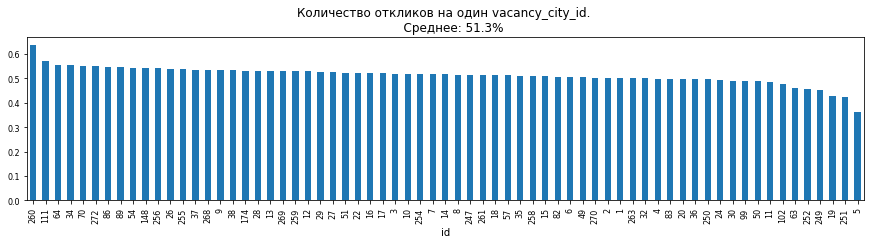

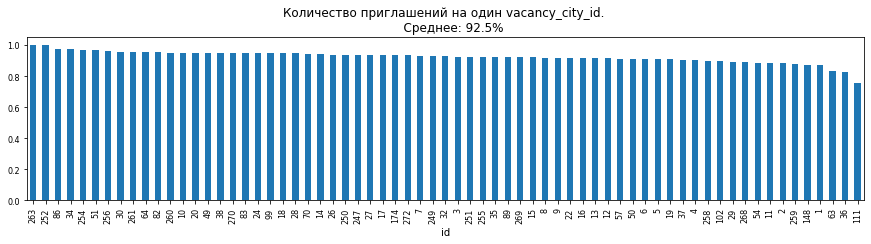

In [23]:
df["resume_city_id"] = df["resume_city_id"].astype("int")

graphplotter(df, "resume_city_id", "target_task_1", "откликов", "bar")

graphplotter(df_task_2, "resume_city_id", "target_task_2", "приглашений", "bar")

graphplotter(df, "vacancy_city_id", "target_task_1", "откликов", "bar")

graphplotter(df_task_2, "vacancy_city_id", "target_task_2", "приглашений", "bar")

Из графиков видно, что существуют такие города, соискатели из которых не откликаются на вакансии.
Это может быть связано с тем, что эти города небольшие, в них нет вакансий, а соискатель не готов к перезду.

В то же время, не существует таких городов, на вакансии в которых не было бы ниодного отклика.
При этом приглашения - не зависят от города ни в резюме, ни в вакансиях.

По графику видно, что в процентном соотношении количество откликов в одном и том же городе совпадает.
Другими словами, город в резюме и вакансии не влияет на вероятность отклика соискателем.

Такое явление может быть в трех случаях:
1. все соискатели готовы к переездам или удаленной работе;
1. датасет описывает рынок труда в одном регионе страны, при этом, признаки `_city_id` описывают крупные города в нем, а `_region_id` - области, районы и т.п.; 
1. датасет сформирован специальным образом, возможно, на нереальных данных.

Последняя гипотеза представляется наиболее реалистичной.

### Регион

Посмотрим количество уникальных регионов в отношении к общей длине датасета.


In [24]:
uniq_printer("resume_region_id", "регионов")

Количество уникальных регионов: 2317 (0.78%)


Регионов на порядок больше городов, что странно.
Кроме того, для вакансий регион отсутствует в принципе. 

Значения признака региога остается не ясным. 
Возможно, имеется в виду район города или целой области.

В рассматриваемом столбце присутствуют пропуски.
Выведем их количество и строки датасета с ними.

In [25]:
df["resume_region_id"].isna().mean()

0.0004967876635539115

In [26]:
df[df["resume_region_id"].isna()].head()

,resume_id,vacancy_id,birth_date,resume_position,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_custom_position,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_description,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_operating_schedule_comment,vacancy_offer_experience_year_id,target_task_1,target_task_2
471,28104597,42582247,1993-01-01,Расклейщик,40000.0,1,False,False,1.0,False,False,79.0,-1.0,NaN,Продавец-кассир (мини кафе Stardogs),3,60000,80000.0,<strong>Мы готовы предложить:</strong><br />\r...,1,1.0,1638554,False,1,NaN,NaN,0,1
2476,28329907,43904916,1984-01-01,Разнорабочий,NaN,1,False,True,2.0,False,True,77.0,-1.0,NaN,Грузчик на мясокомбинат,7,38000,70000.0,Приглашаем на работу вахтовым методом с прожив...,0,-100.0,1615821,False,1,NaN,NaN,0,1
4671,18641674,42465255,1999-05-29,Оператор call-центра,20000.0,2,False,False,1.0,False,False,85.0,-1.0,NaN,Продавец,3,0,32500.0,"<strong>""ЛЕНТА"",</strong>&nbsp;одна из крупней...",0,-100.0,118434,False,2,NaN,NaN,0,1
6899,22582022,43118977,1973-02-14,Товаровед,35000.0,1,False,False,1.0,False,False,81.0,5.0,NaN,Менеджер склада,3,0,52000.0,<strong>Условия:</strong><br />\r\n<ul>\r\n<li...,0,1.0,1613089,False,1,NaN,NaN,0,1
7089,16413529,43821336,1971-04-18,Домработница с проживанием,0.0,1,False,True,4.0,False,False,83.0,4.0,NaN,Горничная в гостиницу,3,24000,28000.0,В связи с расширением&nbsp; в пятизвездочный о...,0,-1.0,331476,True,6,NaN,NaN,0,1


Таких объектов всего 5.
Их удаление не должно оказать значимого эффекта на качество анализа и моделирования.

In [27]:
df = df.dropna(subset=["resume_region_id"], axis=0)
df["resume_region_id"] = df["resume_region_id"].astype("int")

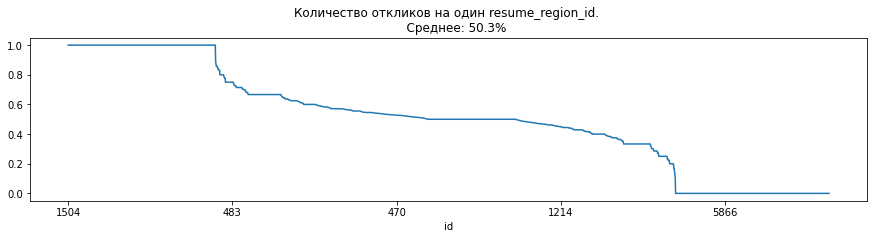

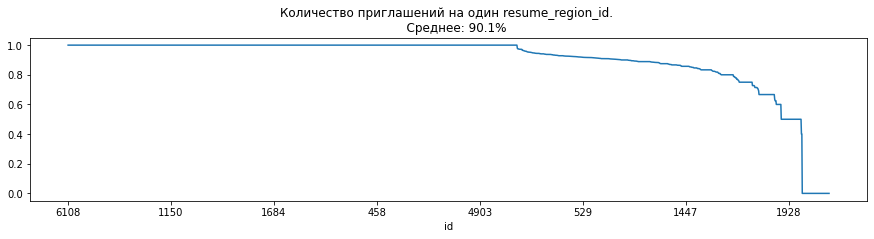

In [28]:
df_task_2 = df[df["target_task_1"] == 1]

graphplotter(df, "resume_region_id", "target_task_1", "откликов")

graphplotter(df_task_2, "resume_region_id", "target_task_2", "приглашений")

По графикам можно сделать вывод, что количество регионов в датасете не просто больше городов, но они еще и сильнее влияют на отклики и приглашения.

### Образование

Посмотрим количество уникальных категорий образования в отношении к общей длине датасета.


In [29]:
uniq_printer("resume_offer_education_id", "категорий образования в резюме")
uniq_printer("vacancy_offer_education_id", "категорий образования в вакансиях")

Количество уникальных категорий образования в резюме: 16 (0.01%)
Количество уникальных категорий образования в вакансиях: 8 (0.0%)


Количество уникальных категорий в вакансиях в 2 раза меньше, чем в резюме.
При этом, на сайте "работа.ру" только 11 градаций образования, а в датасете 16, что странно.

Построим гистограмму по категориям образования в резюме и вакансиях

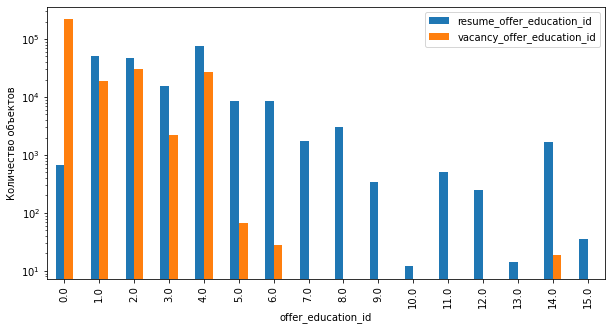

In [30]:
barplotter("offer_education", (10, 5))

Гистограмма в логарифмическом масштабе.

По полученным данным видно, что в вакансиях, как правило, указывают образование с индексами от 0 до 4. 
По всей видимости, они соответствуют отсутствию образования, среднему, средне-специальному, неоконченному высшему, высшему. 
Однако достоверно установить соответствие индекса указанной градации не представляется возможным.

Остальные индексы (5-15) могут быть связаны с учеными степенями, курсами, и комбинацией нескольких предыдущих типов. Например, высшее специалитет + высшее магистр.

Стоит обратить внимание, что индексы образования 10, 13 и 15 в резюме встречаются реже всего. 

В столбце с образованием в резюме присутствуют пропуски.
Выведем их количество и 5 объектов целиком.

In [31]:
df["resume_offer_education_id"].isna().mean()

0.27350335498344336

In [32]:
df[df["resume_offer_education_id"].isna()].head()

,resume_id,vacancy_id,birth_date,resume_position,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_custom_position,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_description,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_operating_schedule_comment,vacancy_offer_experience_year_id,target_task_1,target_task_2
5,26474618,43740592,1998-01-11,Грузчик,21000.0,2,False,False,NaN,False,False,77.0,NaN,4,Грузчик в магазин детских товаров (ночная см...,2,28000,35000.0,"Друзья, открыта вакансия Разнорабочий / Грузчи...",0,-100.0,714925,False,2,NaN,NaN,0,1
9,30077353,43758457,1986-11-23,Водитель,120000.0,1,False,False,NaN,False,False,77.0,NaN,3,Водитель-экспедитор,1,60000,70000.0,<strong><strong>Требования:</strong></strong><...,0,1.0,921078,False,2,NaN,3.0,0,1
17,29001519,43545196,1990-07-22,Кассир (м. Свиблово),45000.0,1,False,False,NaN,False,False,77.0,5.0,3,Продавец-кассир тортиков,1,35000,45000.0,Продавец &ndash; Кассир тортиков.<br /><br /><...,0,NaN,1699509,False,1,NaN,NaN,0,1
26,28004976,43428951,1958-01-01,ассистент,0.0,19,False,False,NaN,False,False,70.0,NaN,415,Официант в вагон-ресторан,7,0,35000.0,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,0,0.0,1422567,False,19,NaN,NaN,0,1
35,26814516,43102138,2001-01-12,Уборщица,25000.0,38,False,False,NaN,False,False,77.0,NaN,54,Тайный покупатель,6,0,25000.0,Это подработка в свободное время от основной р...,0,-100.0,847418,False,38,NaN,NaN,0,1


Можно предположить, что такие пропуски соответствуют отсутствию образования.
Однако оснований достоверно это утверждать нет.

В этой связи введем новую категорию образования `-1`, которую присвоим всем объектам столбца с пропусками.

In [33]:
df["resume_offer_education_id"] = (
    df["resume_offer_education_id"].fillna(-1).astype("int")
)

Посмотрим распределения целевых признаков по категориям образования.

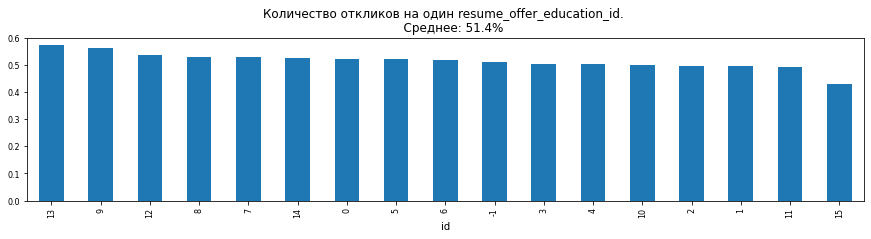

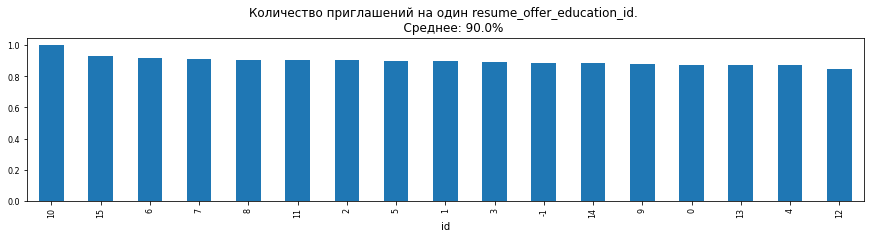

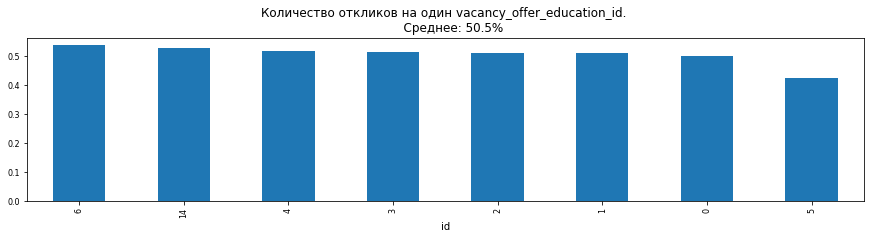

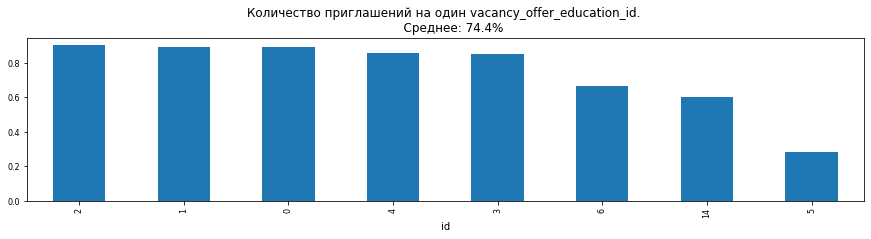

In [34]:
df_task_2 = df[df["target_task_1"] == 1]

graphplotter(df, "resume_offer_education_id", "target_task_1", "откликов", "bar")

graphplotter(
    df_task_2, "resume_offer_education_id", "target_task_2", "приглашений", "bar"
)

graphplotter(df, "vacancy_offer_education_id", "target_task_1", "откликов", "bar")

graphplotter(
    df_task_2, "vacancy_offer_education_id", "target_task_2", "приглашений", "bar"
)

По гистограммам хорошо видно, что уровень образования практически не влияет ни на количество откликов, ни на количество приглашений.

Работодатели приглашают реже в вакансиях, в которых указано образование с индексом 5.
Однако, скорее всего, это объясняется небольшим количеством объектов с таким уровнем образованием в вакансиях.

### Компании

Посмотрим количество уникальных компаний в отношении к общей длине датасета и распределение целевых признаков по компаниям.


In [35]:
uniq_printer("vacany_company_id", "компаний")

Количество уникальных компаний: 22655 (7.61%)


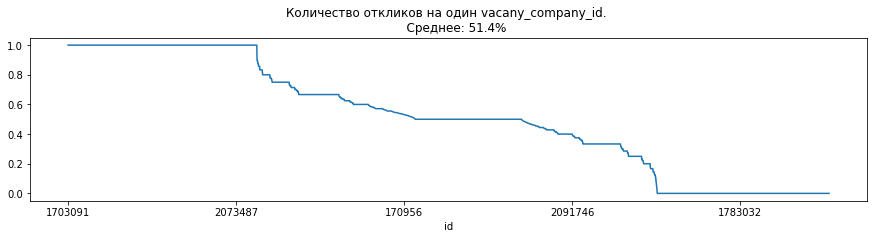

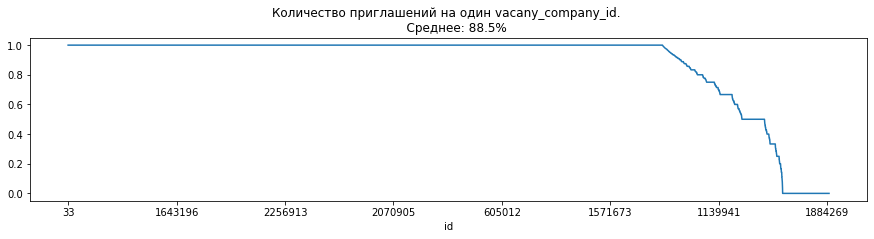

In [36]:
graphplotter(df, "vacany_company_id", "target_task_1", "откликов")

graphplotter(df_task_2, "vacany_company_id", "target_task_2", "приглашений")

Компаний менее 8% от объема всего датасета. 
В абсолютных величинах получается, что на один регион приходится, в среднем, около 10 компаний, а на каждую компанию, в среднем, по 8 вакансий.

Распределение целевых признаков внешне схоже с аналогичным по регионам.

Построим сводную таблицу, сколько компаний в каждом регионе на самом деле.

In [37]:
df.groupby("resume_city_id")["vacany_company_id"].agg({"count"}).sort_values(
    by="count", ascending=False
).head(10)

,count
resume_city_id,
1,198849
2,28131
57,13131
4,5765
35,3053
16,2746
3,2562
6,2389
14,2276


Больше всего компаний в городе №1 - примерно 2/3 от всего датасета.

### График работы

Посмотрим количество уникальных категорий графика работы в отношении к общей длине датасета и распределение целевых признаков по ним.

In [38]:
uniq_printer("vacancy_operating_schedule_id", "категорий графика работы")

Количество уникальных категорий графика работы: 6 (0.0%)


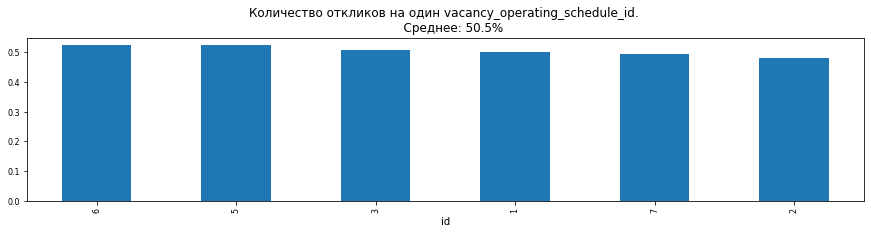

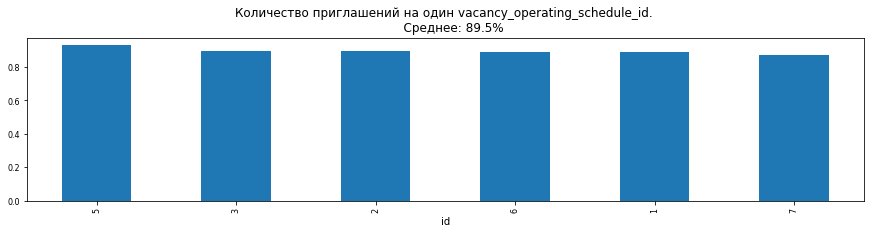

In [39]:
graphplotter(df, "vacancy_operating_schedule_id", "target_task_1", "откликов", "bar")

graphplotter(
    df_task_2, "vacancy_operating_schedule_id", "target_task_2", "приглашений", "bar"
)

Всего 6 категорий расписаний.
По всей видимости, среди них: сменный график, полный рабочий день, удаленная работа, свободный график, вахта, частичная занятость.
Однако установить однозначное соответствие перечисленных категорий и id не представляется возможным.

Примечательно, что тип графика работы не влияет на целевые признаки.

### Стаж работы

Выполним аналогичные действия, дополнительно замену пропусков в столбце на значения `-1`.

In [40]:
uniq_printer("vacancy_offer_experience_year_id", "категорий стажа")

Количество уникальных категорий стажа: 6 (0.0%)


In [41]:
df["vacancy_offer_experience_year_id"] = (
    df["vacancy_offer_experience_year_id"].fillna(-1).astype("int")
)

C:\ProgramData\Anaconda3\envs\praktikum_env_win_new\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


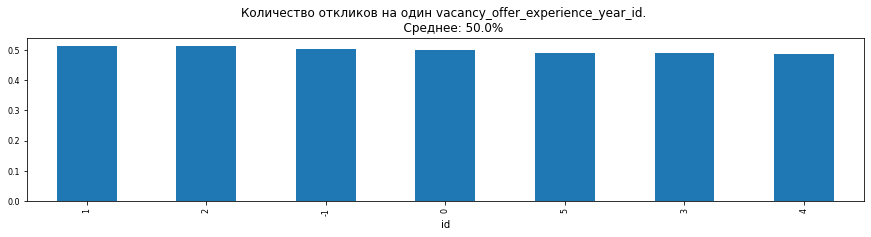

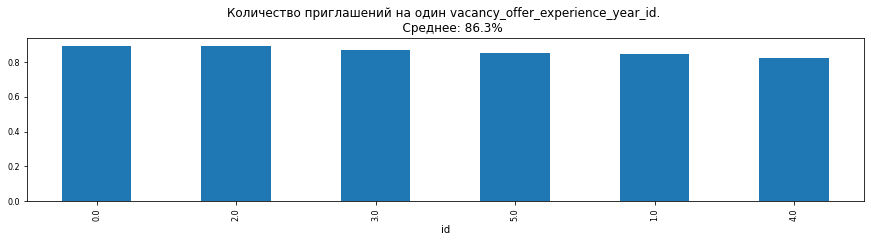

In [42]:
df_task_2["resume_offer_education_id"] = (
    df_task_2["resume_offer_education_id"].fillna(-1).astype("int")
)

graphplotter(df, "vacancy_offer_experience_year_id", "target_task_1", "откликов", "bar")

graphplotter(
    df_task_2, "vacancy_offer_experience_year_id", "target_task_2", "приглашений", "bar"
)

Аналогично категориям расписаний, здесь также 6 категорий, которые не влияют на целевые признаки.
По всей видимости, среди них: без опыта, менее 1 года, 1-2 года, 3-4 года, 5-9 лет, более 10 лет.
Однако установить однозначное соответствие перечисленных категорий и id не представляется возможным.

## Бинарные признаки

В датасете содержаться признаки с булевым типом данных.
Такой тип не позволит использовать модели машинного обучения, в связи с чем переведем их в значения `0/1` и построим гистограммы распределения с разделением по целевым признакам

In [43]:
binary_features = [
    "resume_city_search_job",
    "resume_is_leaving",
    "resume_is_foreign_language",
    "resume_is_upload_photo",
    "vacancy_is_agency",
]

In [44]:
def plotter_2cols(
    features,
    figsize=(12, 17),
    bins="auto",
    kde=False,
    binwidth=None,
    log_scale=(False, False),
    xlim=None,
    ylim=None,
    binrange=None,
):
    _, axs = plt.subplots(len(features), 2, figsize=figsize)

    df_task_2 = df[df["target_task_1"] == 1]
    df_s = [df, df_task_2]
    ax = None

    for i in range(len(features)):
        for j in range(2):
            try:
                ax = axs[i, j]
            except IndexError:
                ax = axs[j]

            sns.histplot(
                data=df_s[j],
                x=features[i],
                bins=bins,
                binwidth=binwidth,
                binrange=binrange,
                hue=y_s[j],
                multiple="dodge",
                ax=ax,
                kde=kde,
                log_scale=log_scale,
            )
            ax.grid(True)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.grid(True)

    plt.show()

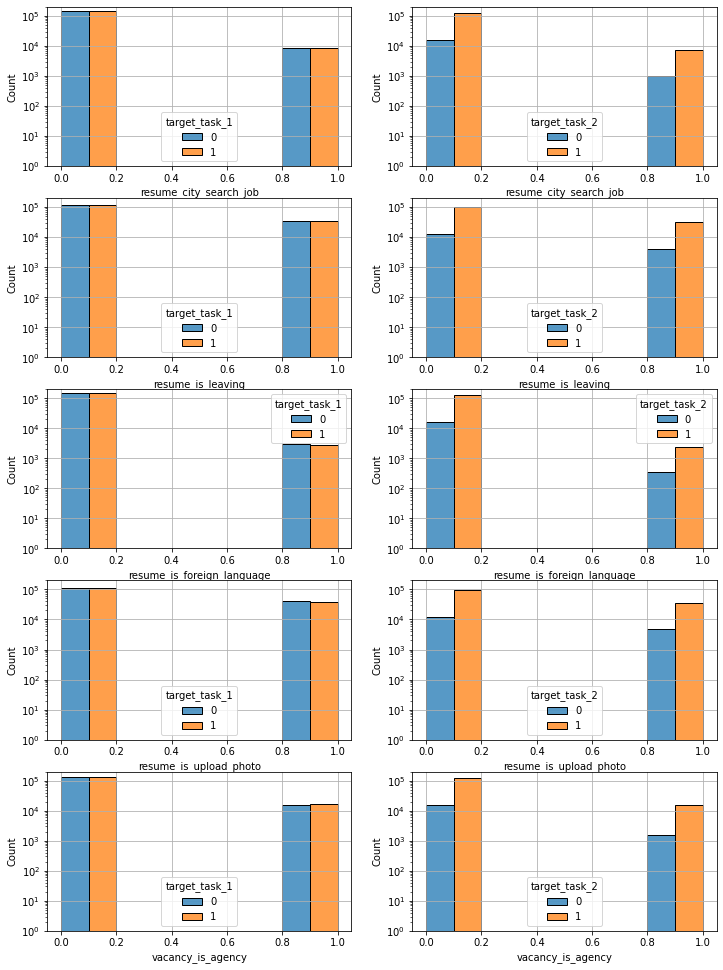

In [45]:
plotter_2cols(binary_features, binwidth=0.2, log_scale=(False, True), ylim=(1, 2e5))

По гистограммам хорошо видно, что для всех построенных признаков в датасете больше объектов со значением `0`, чем `1`.
Однако среди приведенных гистограмм нельзя выделить признак, который в большей степени влияет на целевые, а все распределения соответствуют ранее полученным: для первой задачи 50/50, для второй 90/10.
Такие распределения представляются маловероятными, в связи с чем подтверждается гипотеза о специальной подготовке датасета.

## Непрерывные признаки

Далее рассмотрим четыре признака с непрерывными значениями.

### Зарплата

Выведем распределение значений в столбце.

In [46]:
df["resume_salary_from"].describe()

count    2.275690e+05
mean     4.487384e+04
std      1.710560e+05
min      0.000000e+00
25%      2.635600e+04
50%      4.000000e+04
75%      6.000000e+04
max      7.000012e+07
Name: resume_salary_from, dtype: float64

Значения распределены неравномерно: есть выбросы к в одну, так и в другую сторону.

Для дальнейшего анализа посмотрим распределения в диапазоне значений до 75-го перцентиля, а также срезы по датасету.

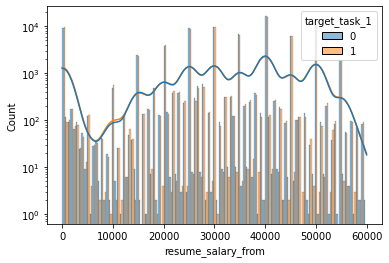

In [47]:
sns.histplot(
    df[df["resume_salary_from"] < 6e4],
    x="resume_salary_from",
    hue="target_task_1",
    multiple="dodge",
    log_scale=(False, True),
    kde=True,
)
plt.show()

Из гистограммы видно, что распределения по целевым признакам практически не меняются (опять!).
При этом имеются скопления у "красивых" значений зарплаты - кратных 5000.
Такое распределение может потребовать в дальнейшем трансформации признака в категориальный для повышения качества модели.

Для анализа возможности обработки выбросов сделаем срезы по датасету, ограничивая диапазон зарплат и изучим объекты визуально анализируя позиции.


In [48]:
df[df["resume_salary_from"] == 0].head()

,resume_id,vacancy_id,birth_date,resume_position,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_custom_position,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_description,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_operating_schedule_comment,vacancy_offer_experience_year_id,target_task_1,target_task_2
25,30128532,43730387,1994-01-01,"Комплектовщик, логист",0.0,4,False,False,1,False,True,85.0,-1.0,231,Комплектовщик,1,45000,65000.0,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,0,NaN,1492651,True,4,NaN,-1,0,1
26,28004976,43428951,1958-01-01,ассистент,0.0,19,False,False,-1,False,False,70.0,NaN,415,Официант в вагон-ресторан,7,0,35000.0,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,0,0.0,1422567,False,19,NaN,-1,0,1
41,28763688,40655024,2000-01-01,"водитель, курьер",0.0,38,False,True,8,False,False,79.0,-1.0,54,Водитель-курьер на личном авто,2,30000,NaN,"Новый удобный формат сотрудничества для тех,ко...",0,-100.0,1583114,False,16,NaN,-1,0,0
46,29880938,42930666,1968-01-01,домработница,0.0,1,False,False,-1,False,False,72.0,NaN,3,Домработница с проживанием,1,120000,150000.0,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,0,3.0,1633749,True,1,NaN,-1,0,1
51,17068440,43195300,1964-11-13,Начальник производства,0.0,70,True,True,4,False,True,87.0,10.0,111,Начальник производства,1,100000,NaN,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,0,3.0,1974357,False,57,NaN,-1,0,1


In [49]:
def slicer(low, high, head, feature="resume_salary_from"):
    t = df[(df[feature] > low) & (df[feature] < high)][
        [
            "resume_position",
            "resume_salary_from",
            "vacancy_custom_position",
            "vacancy_salary_from",
            "vacancy_salary_to",
            "target_task_1",
            "target_task_2",
        ]
    ]

    display(t.head(head))
    print("Количество объектов: ", len(t))

In [50]:
slicer(0, 1e2, 10)

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
1,комплектовщик,50.0,Комплектовщик,50000,NaN,0,1
250,швея,60.0,Швея-моторист,50000,70000.0,0,1
311,продавец,30.0,Старший продавец-кассир,24000,28000.0,0,1
529,комплектовщик,80.0,Комплектовщик,68000,NaN,0,1
592,"курьер, водитель",50.0,Курьер,30000,60000.0,0,1
617,эстетист,50.0,Косметолог-эстетист,50000,100000.0,0,0
757,"бармен, официант",30.0,Официант-бармен (ночные смены),35000,40000.0,0,1
1281,"курьер, менеджер магазина",50.0,Водитель-курьер,30000,55000.0,0,1
1403,курьер,45.0,Курьер,-1,-1.0,0,1
1646,---,35.0,Повар-блинопек,40000,50000.0,0,1


Количество объектов:  1150


In [51]:
slicer(1e2, 2e2, 10)

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
5187,замерщик,150.0,Сметчик-замерщик,150000,NaN,0,1
10190,строитель,110.0,Монтажник трубопроводов,74050,NaN,0,1
22376,"водитель, курьер",150.0,Водитель-экспедитор с личным автомобилем,96000,NaN,0,1
29141,курьер,150.0,Курьер по доставке еды,25000,35000.0,0,1
37238,няня,150.0,Няня для новорожденного,150000,160000.0,0,1
39295,семейная пара,130.0,Семейная пара с проживанием,120000,130000.0,0,1
39814,"мастер-универсал, курьер",120.0,Пеший курьер (Gett Delivery),50000,100000.0,0,1
41895,сварщик,120.0,Сварщик на полуавтомат,117000,NaN,0,1
42130,Медицинская сестра,150.0,Упаковщик на склад косметики,-1,-1.0,0,1
48151,водитель,110.0,Водитель самосвала,100000,150000.0,0,1


Количество объектов:  48


In [52]:
slicer(2e2, 1e3, 10)

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
79663,курьер,300.0,Пеший курьер выходного дня,10000,NaN,0,1
91371,программист,400.0,Frontend-разработчик,-1,-1.0,0,0
109677,продавец,800.0,Продавец-кассир (Ленинский р-он),25000,NaN,0,1
123623,Бухгалтер,700.0,Бухгалтер в единственном лице,-1,-1.0,0,1
160167,работник торгового зала,300.0,Работник торгового зала,20000,25000.0,1,1
187503,сборщик,700.0,Комплектовщик / Сборщик заказов,40000,NaN,1,1
190438,Любая,500.0,Кассир,25000,NaN,1,1
196447,промоутер,300.0,Промоутер,-1,-1.0,1,1
198086,домработница,450.0,Домработница (Заречье),45000,48000.0,1,1
215792,"3d моделлер, конструктор",250.0,Верстальщик-дизайнер,35000,45000.0,1,1


Количество объектов:  10


In [53]:
slicer(1e3, 5e3, 10)

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
117,Курьер с личным автомобилем,3000.0,Курьер с личным автомобилем,1500,2500.0,0,1
374,Мерчендайзер,3000.0,Оператор по сохранению клиентов,30000,NaN,0,1
447,Бригада монолитчиков,3500.0,Плотник-бетонщик на вахту 20/10,37500,42500.0,0,1
509,уборщица,2500.0,"Уборщик/ца (ТРЦ ""РИО"")",7000,7000.0,0,1
1165,"Упаковщик одежды,комплектовщик",1300.0,Сборщик заказов в магазин,47000,53000.0,0,1
1323,Разнорабочий (оплата за смену),1800.0,Упаковщик на производство мыла,55350,66500.0,0,1
1388,грузчик,3035.0,Грузчик доставки,0,34300.0,0,1
1668,Повар г /цех,1800.0,Повар горячего цеха,46000,NaN,0,1
1885,Работа с ежедневной оплатой,1500.0,Продавец-кассир в кафе,30000,45000.0,0,1
2004,охранник,3000.0,Охранник УЧО 4 разряд,30000,45000.0,0,1


Количество объектов:  1014


In [54]:
slicer(5e3, 1e4, 10)

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
5891,Уборщица,8000.0,Мойщик/ца посуды,0,10000.0,0,1
6457,Мерчендайзер,9000.0,Официант Бургер Кинг,25000,25000.0,0,1
7465,повар,5060.0,Повар,30000,45000.0,0,1
9611,семейная пара,7080.0,Семейная пара (помощники по хозяйству),150000,150000.0,0,1
10170,Охранник без лицензии,7000.0,Охранник на склад,81000,108000.0,0,1
11058,Уборщица,9000.0,Уборщик офисных помещений,27092,27092.0,0,1
11115,Бармен-бариста,7000.0,Семейная пара (помощники по хозяйству),150000,150000.0,0,1
14494,Аудитор,6000.0,Аудитор,6000,NaN,0,1
14748,Менеджер по продажам (стажер),9000.0,Менеджер по продажам,15000,18000.0,0,1
15895,Уборщица помещений,7000.0,Мойщик посуды,14000,NaN,0,1


Количество объектов:  268


In [55]:
slicer(5e5, float("inf"), 10)

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
1450,"МЕНЕДЖЕР -ЭКСПЕРТ, по РАЗВИТИЮ РЕКЛАМЫ-БИЗНЕСА...",1000000.0,Агент по продажам,30000,150000.0,0,1
6743,администратор,600000.0,Менеджер ресторана (премиум),-1,-1.0,0,1
20932,"фасовщик, Грузчик на склад спецодежды (вахта)",670000.0,Упаковщик на мясокомбинат,70200,NaN,0,1
21140,Инженер,1000000.0,Менеджер-оператор по подбору персонала,20000,50000.0,0,1
28002,уборщица,650000.0,Уборщик/ца,30000,NaN,0,1
33284,мастер ногтевого сервиса,2000000.0,Мастер маникюра-педикюра,50000,NaN,0,1
45914,курьер,1000000.0,Курьер,47500,54500.0,0,1
56751,монтажник,800000.0,Электромонтажник-слаботочник систем,50000,80000.0,0,1
60400,курьер,1000000.0,Курьер,30000,NaN,0,0
63755,администратор,600000.0,Оператор call-центра (удаленно),24600,52000.0,0,1


Количество объектов:  51


Анализ срезов датасета позволяет сделать следующие выводы:
- Значение 0 - скорее всего, равносильно не указыванию З/П совсем.  
- Значения от 0 до 100 - указана зарплата в тысячах рублей. 
- Значения от 100 до 10 000 - указана зарплата в тысячах рублей или зарплата за час/смену/неделю/месяц. Разделить одно от другого практически невозможно.
- Некоторые объекты со значениями более 500 000 выглядят как ошибки пользователей.

Определим процент во всем датасете объектов с З/П в резюме менее 10 000 и более 500 000.

In [56]:
len(
    df[
        ((df["resume_salary_from"] < 1e4) | (df["resume_salary_from"] > 5e5))
        & (df["resume_salary_from"] != 0)
    ]
) / len(df)

0.010229509077597846

Таких объектов чуть более 1%, в связи с чем, их можно безболезненно исключить из рассмотрения.

In [57]:
df = df.drop(
    df[
        ((df["resume_salary_from"] < 1e4) | (df["resume_salary_from"] > 5e5))
        & (df["resume_salary_from"] != 0)
    ].index,
    axis=0,
)

Обработаем пропуски и нулевые значения, присвоив всем значение `-1`.
Построим гистгорамму без таких значений.

In [58]:
df["resume_salary_from"].isna().mean()

0.238182003257329

In [59]:
df.loc[df["resume_salary_from"] == 0, "resume_salary_from"] = -1
df["resume_salary_from"] = df["resume_salary_from"].fillna(-1)

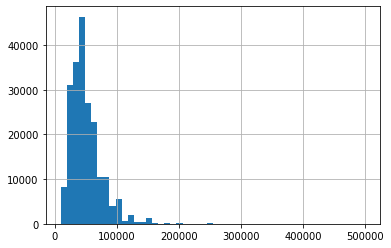

In [60]:
df[df["resume_salary_from"] > 0]["resume_salary_from"].hist(bins=50)
plt.show()

Гистограмма соответствует распределению Пуассона с длинным хвостом, что ожидаемо для распределения зарплат.

Аналогичным образом проанализируем и обработаем признаки **в вакансиях**.
Сперва признак верхней границы "вилки".

In [61]:
df["vacancy_salary_from"].describe()

count    294720.000000
mean      40818.199413
std       28848.554799
min          -1.000000
25%       25000.000000
50%       40000.000000
75%       55000.000000
max      900000.000000
Name: vacancy_salary_from, dtype: float64

In [62]:
slicer(-2, 1, 10, "vacancy_salary_from")

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
3,Дизайнер,35000.0,Дизайнер интерьера,-1,-1.0,0,1
4,Помощник юриста/Младший юрист,45000.0,Администратор выходного дня,-1,-1.0,0,1
8,водитель,40000.0,Водитель-курьер с личным автомобилем,0,95000.0,0,1
15,начальник,-1.0,Начальник юридического отдела,-1,-1.0,0,1
18,Продавец-консультант,45000.0,Помощник повара,0,47000.0,0,1
23,Продавец-кассир,40000.0,Продавец-кассир,-1,-1.0,0,1
26,ассистент,-1.0,Официант в вагон-ресторан,0,35000.0,0,1
27,Бухгалтер,40000.0,Бухгалтер,-1,-1.0,0,1
31,Водитель,90000.0,Подсобный рабочий (мясное производство),0,38000.0,0,1
35,Уборщица,25000.0,Тайный покупатель,0,25000.0,0,1


Количество объектов:  42381


In [63]:
slicer(0, 1e4, 10, "vacancy_salary_from")

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
861,Промоутер,-1.0,Промоутер,1000,NaN,0,1
947,Администратор,-1.0,Курьер-промоутер,2000,2300.0,0,1
992,Охранник,25000.0,Охранник,2480,2870.0,0,1
1269,Домработница,50000.0,Домработница,3500,5000.0,0,1
1389,аудитор,25000.0,Аудитор,3000,5000.0,0,1
1713,Курьер,-1.0,Курьер internet-магазина,1600,2000.0,0,1
1780,Электромонтажник,35000.0,Охранник на вахту,1500,1700.0,0,1
1986,менеджер,-1.0,Телемаркетолог,7000,NaN,0,1
2100,разнорабочий,-1.0,Упаковщик на склад,1100,NaN,0,1
2711,"Охранник, Охранник в агрокомплекс, Охранник в ...",65000.0,Охранник с лицензией,1800,1800.0,0,1


Количество объектов:  1126


In [64]:
slicer(2e5, float("inf"), 10, "vacancy_salary_from")

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
732,няня,-1.0,Гувернантка (вахта),240000,NaN,0,0
1025,Директор ОВиК,90000.0,Исполнительный директор,450000,NaN,0,0
5396,"Няня, учитель",75000.0,Гувернантка (вахта),240000,NaN,0,1
9950,Агент по аренде недвижимости,300000.0,Агент по аренде недвижимости,300000,NaN,0,1
10992,Няня,60000.0,Гувернантка (вахта),240000,NaN,0,1
13165,водитель-экспедитор,200000.0,Водитель с личным грузовым авто 10т,210000,NaN,0,1
14094,Менеджер по продажам,50000.0,Менеджер по продажам,300000,NaN,0,1
14378,Няня,75000.0,Гувернантка (вахта),240000,NaN,0,1
15042,Главный по сторис / Head of Stories,250000.0,Главный по сторис / Head of Stories,250000,NaN,0,0
15976,"Горничная, Гувернантка (вахта), Няня к девочке",30000.0,Гувернантка (вахта),240000,NaN,0,1


Количество объектов:  267


В случае с рассмотренным признаком большие значения не похожи на выбросы или ошибки, а значит, их отсекать не будем.
В то же время, выводы по значениям менее 10 000 аналогичные.

In [65]:
len(df[(df["vacancy_salary_from"] < 1e4) & (df["vacancy_salary_from"] > 0)]) / len(df)

0.0038205754614549403

Аналогично, исключим объекты с з/п менее 10 000.

In [66]:
df = df.drop(
    df[
        ((df["vacancy_salary_from"] < 1e4) | (df["vacancy_salary_from"] > 5e5))
        & (df["vacancy_salary_from"] > 0)
    ].index,
    axis=0,
).reset_index(drop=True)
df.loc[df["vacancy_salary_from"] == 0, "vacancy_salary_from"] = -1

Теперь посмотрим на признак верхней границы "вилки".

In [67]:
df["vacancy_salary_to"].describe()

count    2.034620e+05
mean     6.055263e+04
std      5.505189e+04
min     -1.000000e+00
25%      3.500000e+04
50%      5.000000e+04
75%      8.000000e+04
max      3.000000e+06
Name: vacancy_salary_to, dtype: float64

In [68]:
slicer(0, 1e4, 10, "vacancy_salary_to")

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
2013,промоутер,15000.0,Промоутер,-1,1350.0,0,1
4482,Монтажник оборудования связи,40000.0,Аудитор,-1,5000.0,0,1
5304,"Начальник охраны, Начальник отдела, Охранник, ...",65000.0,Старший смены,-1,4000.0,0,1
6040,бухгалтер,-1.0,Бухгалтер,-1,5000.0,0,1
9832,кладовщик,-1.0,Кладовщик,-1,9900.0,0,1
11754,Бухгалтер,-1.0,Бухгалтер,-1,5000.0,0,1
12036,палатная медсестра,36000.0,Медицинская сестра,-1,3500.0,0,1
15009,Медсестра,50000.0,Медицинская сестра (м. Новохохловская),-1,3500.0,0,1
15249,уборщица,28000.0,Уборщик/ца служебных помещений,-1,8000.0,0,1
15662,промоутер,-1.0,Промоутер,-1,1350.0,0,1


Количество объектов:  104


In [69]:
slicer(5e5, float("inf"), 10, "vacancy_salary_to")

,resume_position,resume_salary_from,vacancy_custom_position,vacancy_salary_from,vacancy_salary_to,target_task_1,target_task_2
1689,Администратор,50000.0,Менеджер по продаже недвижимости (м. Полянка),115000,750000.0,0,1
14594,продавец,45000.0,Риелтор по жилой недвижимости,150000,550000.0,0,1
18433,Разнорабочий,-1.0,Менеджер по продаже недвижимости (м. Полянка),115000,750000.0,0,1
23341,"Менеджер по продажам, директор",75000.0,Менеджер по продаже недвижимости (м. Полянка),115000,750000.0,0,1
29124,Менеджер по оптовым продажам,50000.0,Менеджер по продаже недвижимости (м. Полянка),115000,750000.0,0,0
29987,Слесарь по ремонту оборудования,-1.0,Менеджер по продаже недвижимости (м. Полянка),115000,750000.0,0,1
43022,Персональный водитель со знанием английского я...,60000.0,Брокер по аренде и продаже коммерческой недвиж...,100000,3000000.0,0,1
45985,Менеджер по продажам,40000.0,Менеджер по продаже недвижимости (м. Полянка),115000,750000.0,0,1
59182,риэлтор,100000.0,"Агент по недвижимости, брокер, риэлтор",40000,700000.0,0,1
63500,Менеджер по работе с клиентами,40000.0,Менеджер по работе с клиентами,50000,650000.0,0,1


Количество объектов:  57


Выводы аналогичны полученным при анализе нижнего диапазона "вилки".

In [70]:
df = df.drop(
    df[(df["vacancy_salary_to"] < 1e4) & (df["vacancy_salary_to"] > 0)].index, axis=0
).reset_index(drop=True)

df.loc[df["vacancy_salary_to"] == 0, "vacancy_salary_to"] = -1

In [71]:
df["vacancy_salary_to"].isna().mean()

0.30709235565701826

In [72]:
df["vacancy_salary_to"] = df["vacancy_salary_to"].fillna(-1)
df["vacancy_salary_to"].isna().mean()

0.0

Обновим датасет для второй задачи и построим графики распределения зарплаты в зависимости от целевой переменной.

In [73]:
df_task_2 = df[df["target_task_1"] == 1]

In [74]:
salary_features = ["resume_salary_from", "vacancy_salary_from", "vacancy_salary_to"]

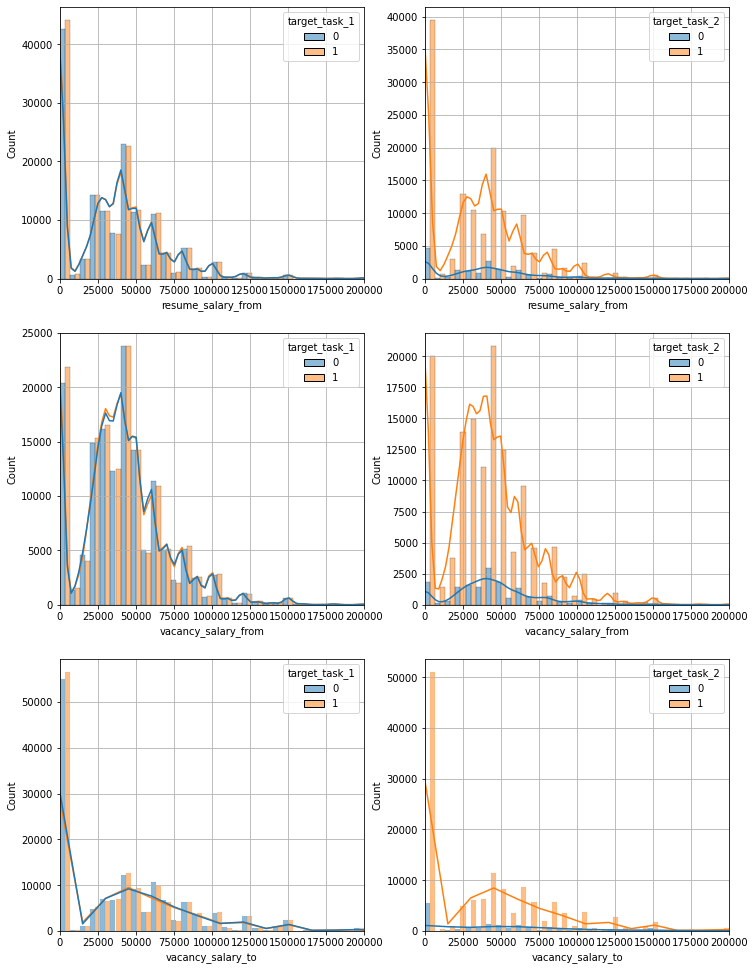

In [75]:
plotter_2cols(salary_features, bins=30, kde=True, xlim=(-1, 2e5), binrange=(-1, 2e5))

На всех графиках, для всех бинов сохраняется распределение зарплат по целевым признакам.
Так, для первой задачи - это 50/50, а для второй 90/10.

Посмотрим, как влияет образование на уровень зарплат с раскраской по целевым переменным.

In [76]:
def salary_boxplotter(df, target, xfeature):

    for salary_feature in salary_features:
        plt.figure(figsize=(25, 4))
        plt.ylim(-1, 2e5)

        sns.boxplot(
            data=df, x=xfeature, y=salary_feature, hue=target, palette=["m", "g"]
        )
        sns.stripplot(x=xfeature, y=salary_feature, data=df, color=".3", size=2)
        plt.grid(True)

        plt.show()

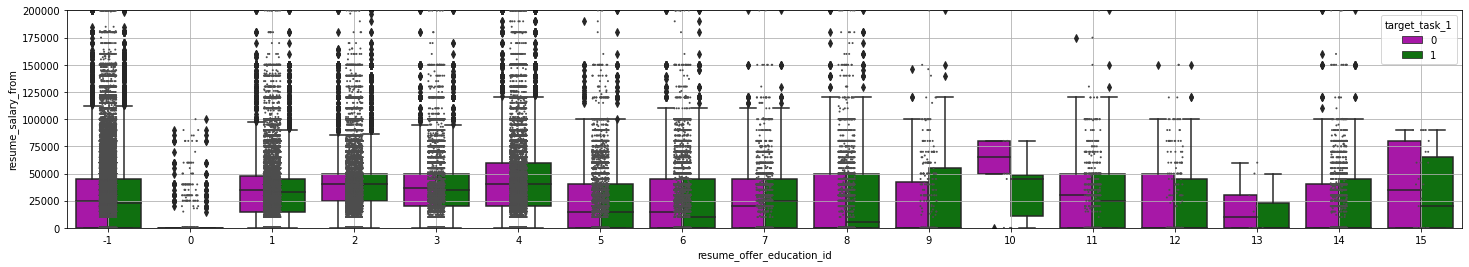

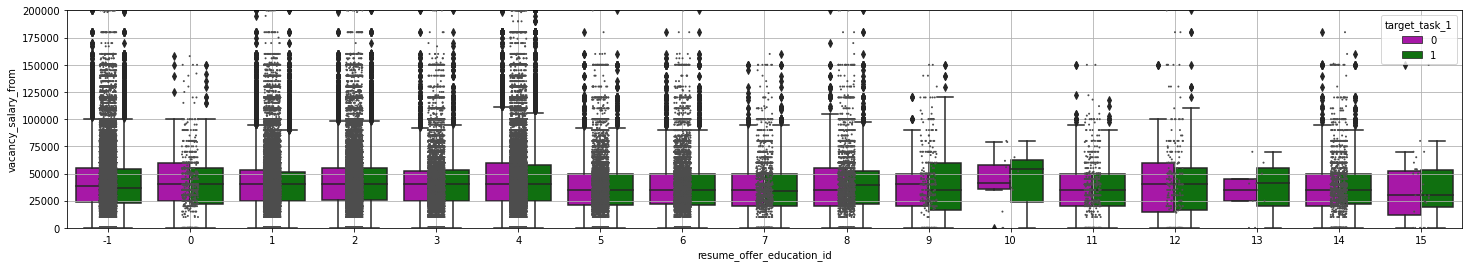

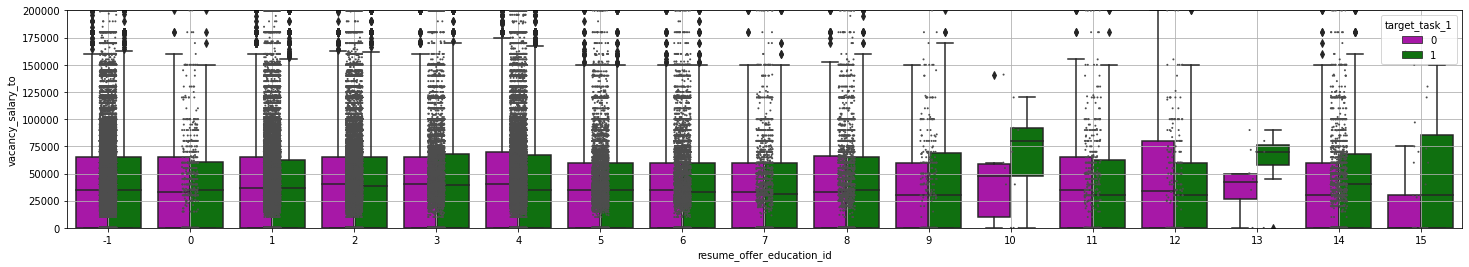

In [77]:
salary_boxplotter(df, "target_task_1", "resume_offer_education_id")

Бросается в глаза, что зарплатные ожидания соответствют нижнему пределу "вилки" вакансий, но ниже верхнего.

Распределение объектов с образованием в резюме №10 выбивается из общей массы.
Парадокс заключается в том, что соискатели с этим образованием и высокими зарплатными ожиданиями не откликаются на предложенные вакансии. 
В тоже время те из них, что откликнулись, сделали это на вакансии с высокой верхней границей "вилки".
Такое поведение может быть свойственно лицам с заниженной самооценкой, например, студентам.  
Не аналогичное, но похожее распределение пользователей с образованием №13.
Они так же откликаются только на вакансии с высокой верхней границей "вилки".
Стоит отметить, что количество объектов для указанных категорий очень мало, что может объяснить наблюдаемый эффект.

Для обеих рассмотренных категорий, а также для категории пользователей с образованием №15 характерно наличие большего разброса как зарплатных ожиданий, так и размера "вилки".

Пользователи с образованием №0 чаще всего не указывают свои зарплатные ожидания.
Такое поведение может быть свойственно лицам без образования.

Посмотрим аналогичные графики для задачи №2.

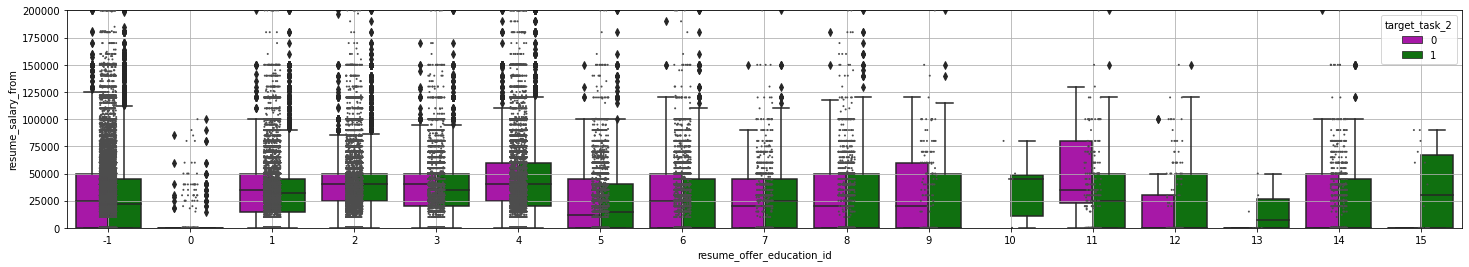

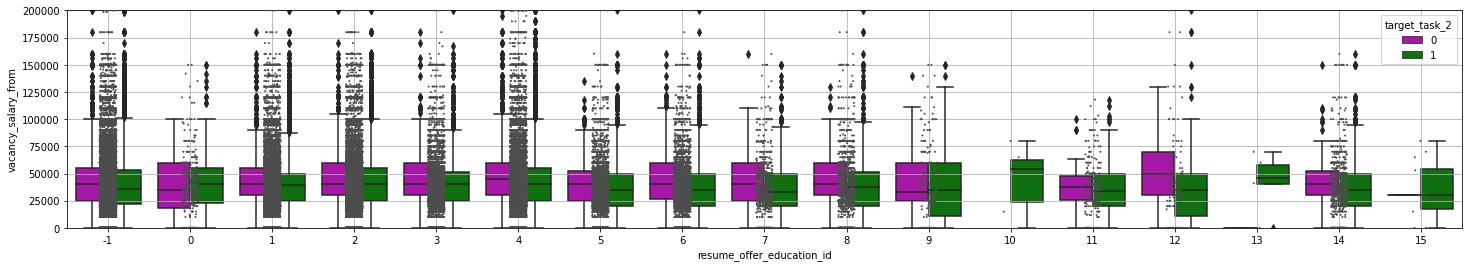

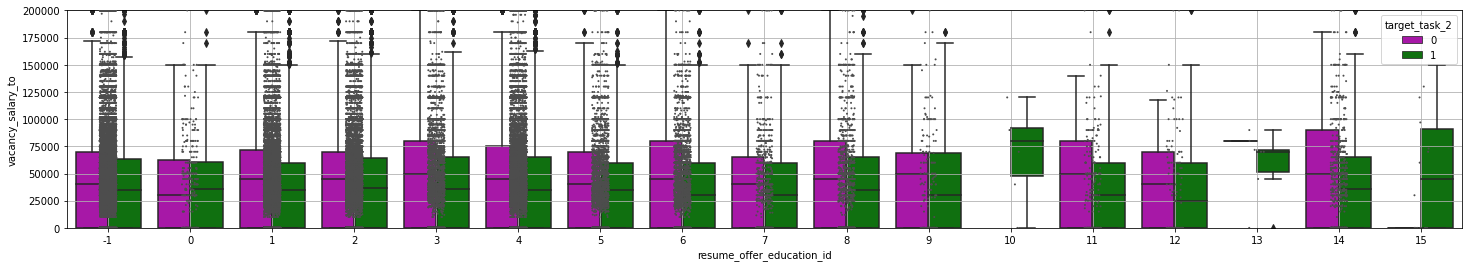

In [78]:
salary_boxplotter(df_task_2, "target_task_2", "resume_offer_education_id")

Здесь так же выделяются пользователи с образованием №10, №13 и №15 - их приглашают практически в 100% случаев, не зависимо от зарплатных ожиданий или "вилки".

Посмотрим аналогичные графики для требуемого образования в вакансиях.

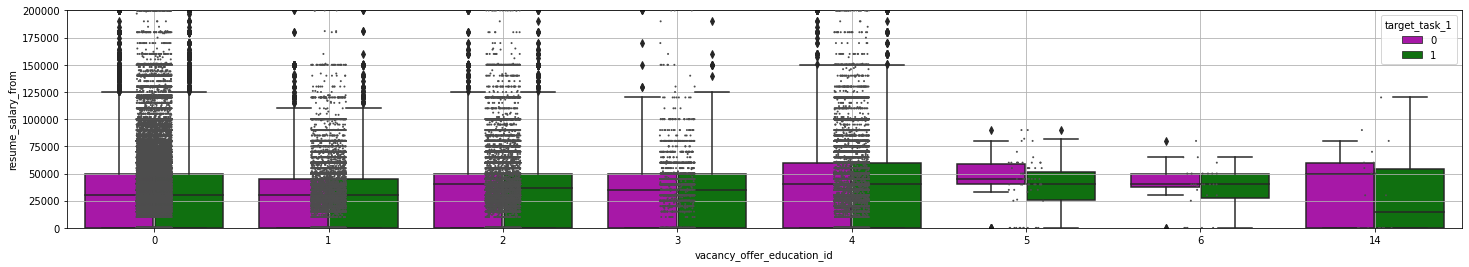

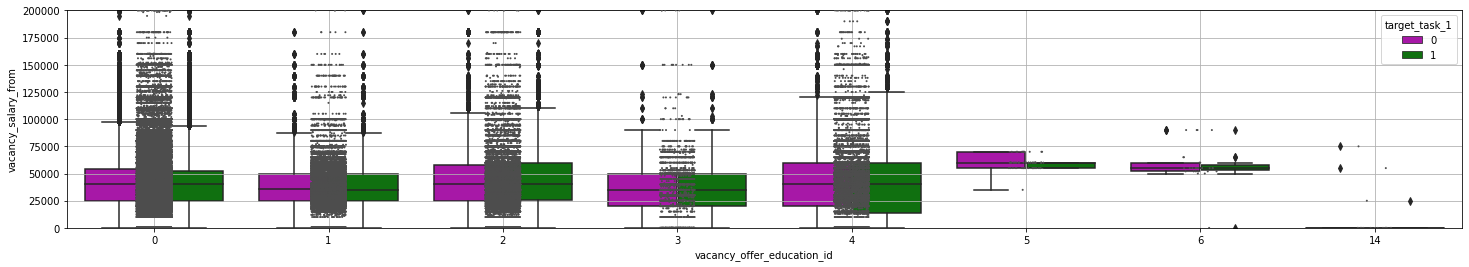

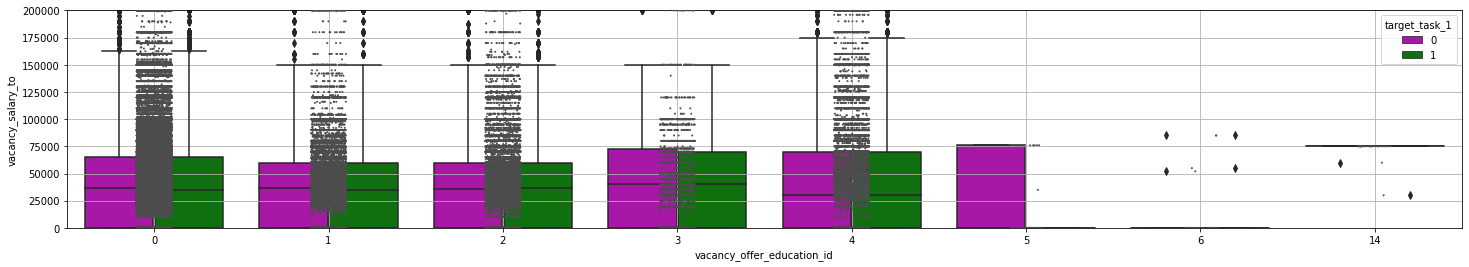

In [79]:
salary_boxplotter(df, "target_task_1", "vacancy_offer_education_id")

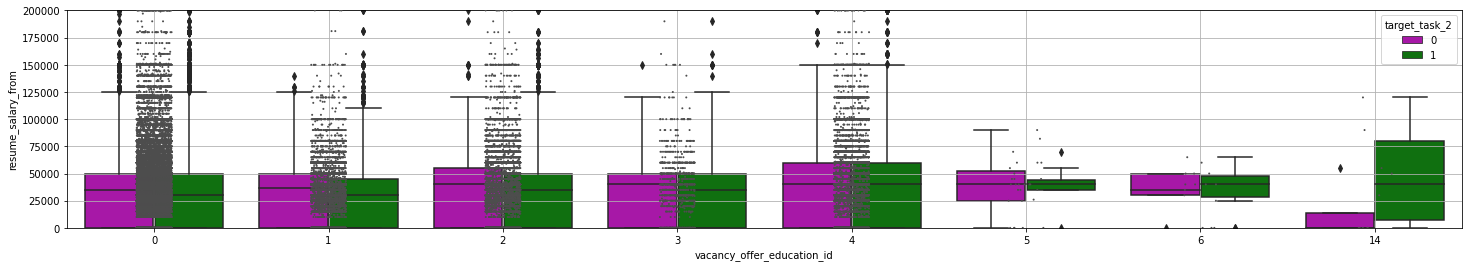

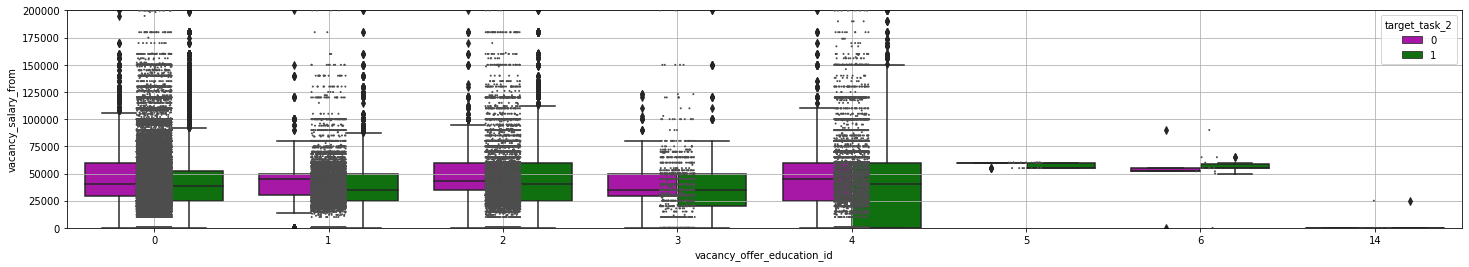

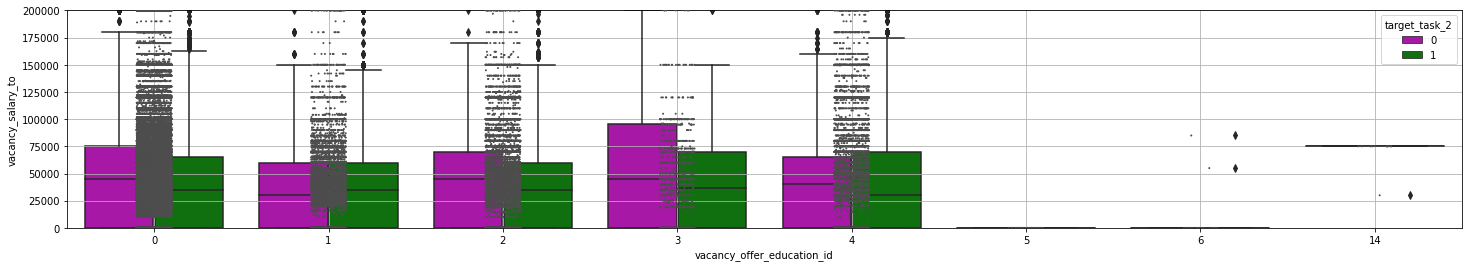

In [80]:
salary_boxplotter(df_task_2, "target_task_2", "vacancy_offer_education_id")

In [81]:
df[(df["vacancy_offer_education_id"] >= 5)]["vacancy_offer_education_id"].sum() / len(
    df
)

0.002603199482085967

Хорошо видно, что в вакансиях, как правило, указывают образование от 0 до 4. 
При этом, зарплатные ожидания при откликах на вакансии с таким требованием увеличиваются при увеличении с увеличением id.

Вакансий с требуемым образованием 5, 6 или 14 менее 0,3% во всем датасете.
В принципе, их можно считать выбросами и исключить из рассмотрения (пока не будем этого делать).

Построим распределения по типам требуемого в вакансиях опыта.

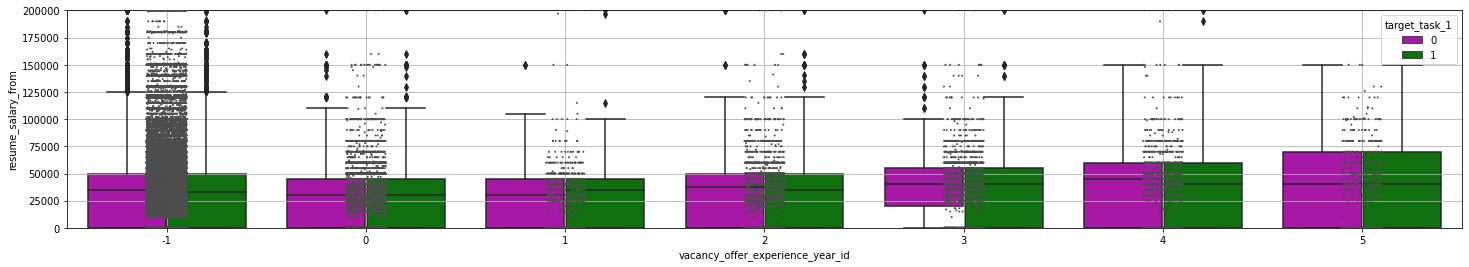

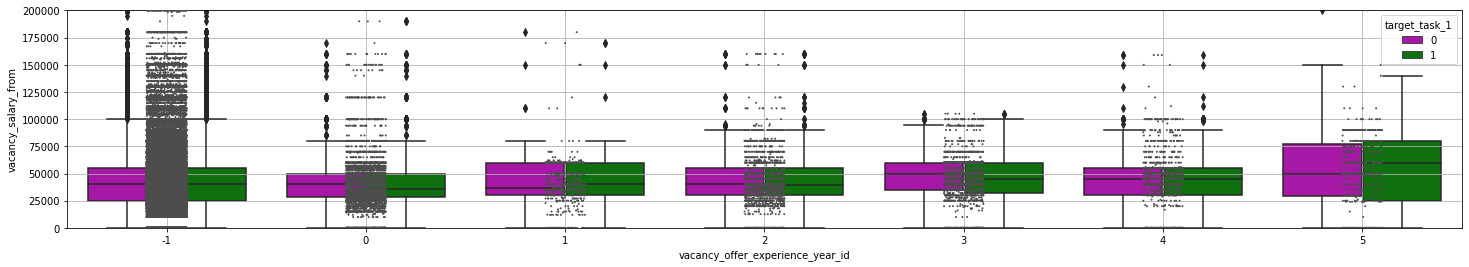

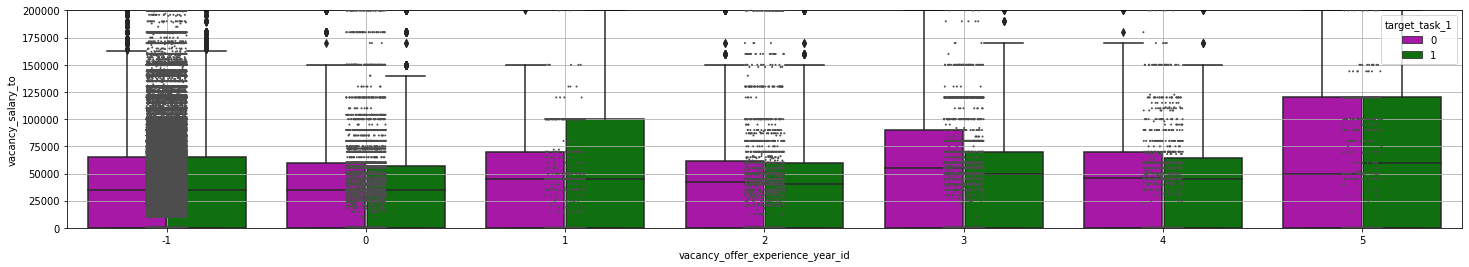

In [82]:
salary_boxplotter(df, "target_task_1", "vacancy_offer_experience_year_id")

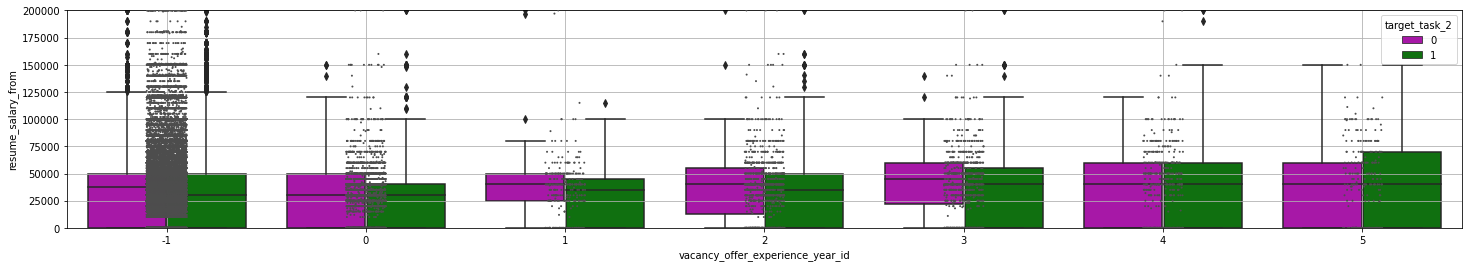

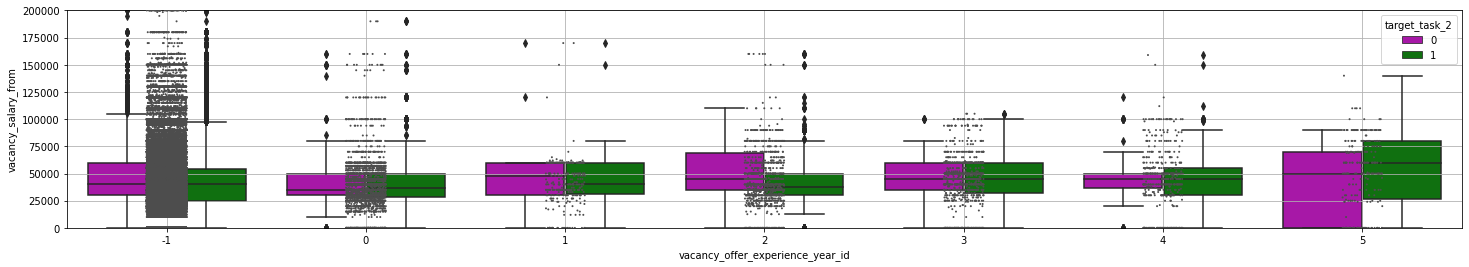

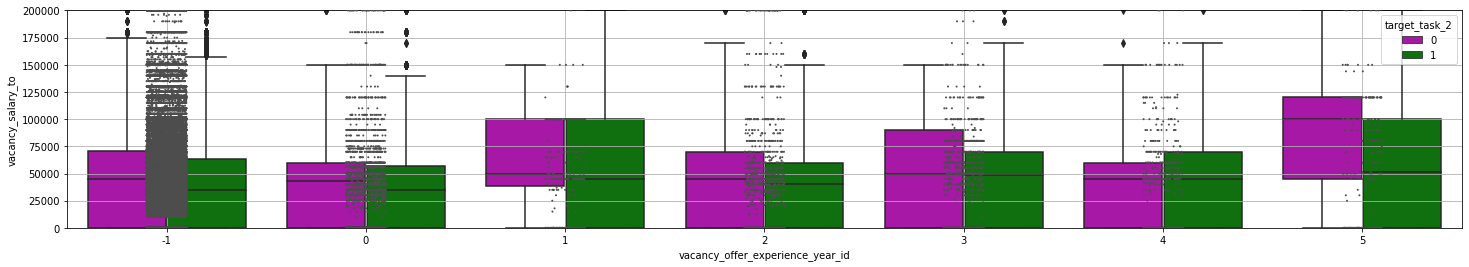

In [83]:
salary_boxplotter(df_task_2, "target_task_2", "vacancy_offer_experience_year_id")

Примичательно, что с увеличением опыта увеличиваются значения 3-го квантиля как зарплатных ожиданий в резюме, так и диапазона вилки. 
При этом среднее значение остается примерно на том же уровне.

### Заполнение резюме

Построим графики распределения значений.

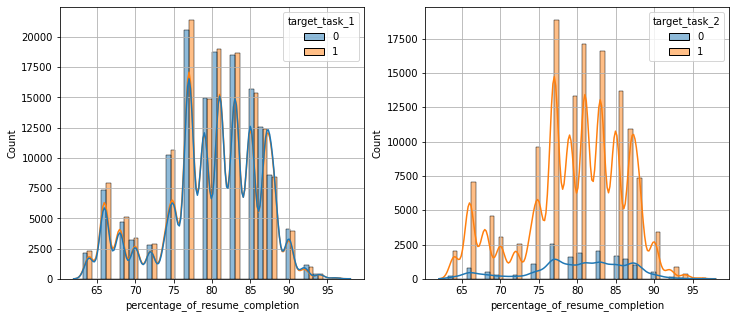

In [84]:
plotter_2cols(["percentage_of_resume_completion"], figsize=(12, 5), bins=30, kde=True)

Результат аналогичен полученному ранее об одинаковости распределения данных в датасете по всему датасету.

Больше всего объектов в датасете с заполнением резюме 

### Обработка даты рождения

Для обработки данных о дате рождения сначала переведем их в формат даты, а затем выделим только значения года.

In [85]:
df["birth_date"] = pd.to_datetime(df["birth_date"], format="%Y-%m-%d").dt.year

In [86]:
df["birth_date"].describe()

count    293438.000000
mean       1982.622448
std          12.661471
min        1899.000000
25%        1973.000000
50%        1983.000000
75%        1993.000000
max        2018.000000
Name: birth_date, dtype: float64

Проанализируем очень маленькие и очень большие значения по признаку.

In [87]:
df[df["birth_date"] < 1940]  # 82 года

,resume_id,vacancy_id,birth_date,resume_position,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_custom_position,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_description,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_operating_schedule_comment,vacancy_offer_experience_year_id,target_task_1,target_task_2
646,29635011,43886052,1900.0,Бухгалтер,40000.0,1,False,False,4,False,True,87.0,NaN,4,Главный бухгалтер,1,50000,70000.0,<strong><strong>Обязанности:</strong></strong>...,4,5.0,211578,False,2,NaN,-1,0,1
1529,29409209,43464556,1905.0,повар,-1.0,1,False,False,-1,False,False,64.0,NaN,3,Повар-пиццамейкер в Domino's Pizza (м. Академи...,2,40000,45000.0,<strong>Domino's Pizza - всемирно известная ме...,0,-100.0,1744214,False,1,NaN,-1,0,1
2303,28475358,43000577,1901.0,продавец,-1.0,1,False,False,-1,False,False,66.0,NaN,328,Продавец-кассир (Центр),1,21000,-1.0,<ul>\r\n<li><strong>&nbsp;</strong><br /> <str...,0,-100.0,1510400,False,3,NaN,-1,0,1
6111,12043110,42146916,1930.0,Пекарь-кондитер,25000.0,1,False,False,2,True,False,83.0,NaN,3,Пекарь-кондитер,1,50000,-1.0,"<strong>Вакансия компании ООО ""ВЕНТА""</strong>...",0,3.0,1636491,False,1,NaN,-1,0,1
8279,22323627,43381054,1937.0,"Директор по персоналу, HR бизнес партнёр, мене...",70000.0,4,False,True,4,False,False,81.0,NaN,231,Менеджер по подбору персонала (удаленно),6,50000,60000.0,&nbsp;<br />&nbsp;<br /><strong>Обязанности:</...,0,1.0,1682281,False,255,NaN,-1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287188,27455577,42770153,1912.0,"грузчик, комплектовщик",70000.0,1,False,True,-1,False,False,74.0,NaN,3,Грузчик-комплектовщик,7,70000,-1.0,В крупную и стабильную компанию требуются на р...,0,-100.0,1749859,False,1,NaN,-1,1,1
289275,27831673,43153395,1917.0,продавец продуктов,35000.0,1,False,False,-1,False,False,75.0,NaN,1239,Продавец,3,40000,-1.0,<strong>В 2020 году &ldquo;Азбука Вкуса&rdquo;...,0,NaN,121368,False,57,NaN,-1,1,1
289721,27476267,43112541,1907.0,Водитель с личным автомобилем,50000.0,1,False,False,1,False,False,77.0,0.0,3,Водитель на служебном автомобиле (ночные смены),1,50000,50000.0,<strong><strong>Обязанности:</strong></strong>...,0,3.0,1127279,False,1,NaN,-1,1,0
290005,24327966,42394858,1900.0,"Специалист по вентиляции, отоплению, кондицион...",80000.0,8,False,True,4,False,True,90.0,NaN,305,Техник по обслуживанию вентиляции и кондициони...,1,55000,-1.0,Стабильно и динамично развивающейся компании О...,2,2.0,655811,False,2,NaN,-1,1,1


In [88]:
df[df["birth_date"] > 2016]  # 18 лет

,resume_id,vacancy_id,birth_date,resume_position,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_custom_position,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_description,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_operating_schedule_comment,vacancy_offer_experience_year_id,target_task_1,target_task_2
158245,23449631,43537572,2018.0,"Журналист, редактор, руководитель пресс-центра...",40000.0,24,False,True,4,False,False,85.0,NaN,156,Копирайтер,6,-1,-1.0,Добрый день. Меня зовут Андрей. Я представляю ...,4,-100.0,1609511,False,2,NaN,-1,1,1
188597,23481322,42928834,2018.0,NaN,-1.0,9,False,False,0,False,False,74.0,NaN,239,Переводчик-копирайтер с английского языка,6,20000,90000.0,Требуются Копирайтеры для написания текстовых ...,0,-100.0,1288224,False,1,NaN,-1,1,1
191973,23449631,43593736,2018.0,"Журналист, редактор, руководитель пресс-центра...",40000.0,24,False,True,4,False,False,85.0,NaN,156,Корреспондент отдела актуальной справочной инф...,6,25000,-1.0,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,0,1.0,681594,False,1,NaN,-1,1,1


Очень большие и маленькие значения распределения года рождения могут быть вызваны опечатками / ошибками / неточностями при заполнении данных.
Однако достоверно такие значения не восстановить, в связи с чем требуется их исключение.

In [89]:
df[df["birth_date"].isna()]["resume_id"].count()

47

In [90]:
df = df.drop(
    df[
        (df["birth_date"] < 1940) | (df["birth_date"] > 2006) | df["birth_date"].isna()
    ].index
)

Посмотрим на распределение признака.

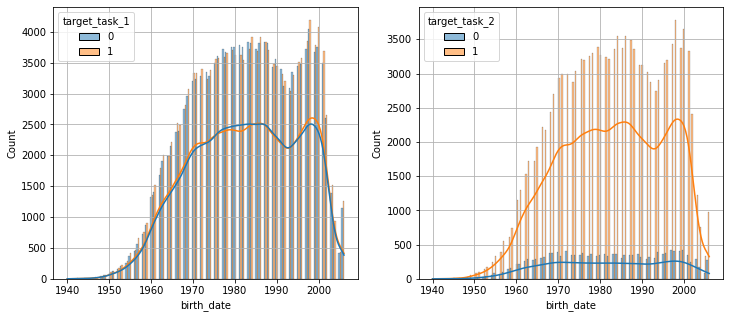

In [91]:
plotter_2cols(["birth_date"], figsize=(12, 5), bins=100, kde=True)

Из гистограмм видно, что распределения по целевым признакам не изменились.

При этом, присутствует "сезонность" у определенных годов: в конце 1990-х и второй половины 1980-х, а для рожденных в начале 1990-х, наоборот, наблюдается спад активности. 
Проанализируем найденный эффект, построив сводную таблицу.

In [92]:
df["birth_date"].value_counts().head(10)

1998.0    8233
2000.0    7824
1984.0    7735
1986.0    7730
1987.0    7679
1997.0    7580
1983.0    7551
1988.0    7519
1979.0    7468
1999.0    7452
Name: birth_date, dtype: int64

Значения подтверждают сделанные раннее выводы, которые могут объясняться тем, что пользователи 1997-2000 г.р. - это "свежие" выпускники ВУЗов, которые активно ищут свое первое место работы. Следующая группа пользователей 1983-1987 г.р. - могут пользователи с кризисом среднего возраста, характеризующимся поисками нового места работы.


### Стаж работы

Проверим количество уникальных значений признака с количеством лет опыта.

In [93]:
df["resume_offer_experience_year_count"].unique()

array([   0.,    5.,   nan,    3.,    2.,   -1.,   10., -100.,    4.,
          1.,    9.,    6.,   20.,   13.,   12.,   30.,    7.,    8.,
         36.,   11.,   31.,   23.,   35.,   14.,   15.,   22.,   26.,
         25.,   21.,   28.,   17.,   18.,   32.,   27.,   19.,   29.,
         33.,   40.,   42.,   24.,   16.,   55., -987.,   47.,   48.])

Неожиданные значения `-987`, `-100` и `-1`.
Это может быть обозначение пропусков с различными категориями.
Уровняем их и присвоим значение `-1`.
Так же значение `-1` присвоим всем остальным пропускам.

In [94]:
df.loc[
    df["resume_offer_experience_year_count"] < -1, "resume_offer_experience_year_count"
] = -1
df["resume_offer_experience_year_count"] = df[
    "resume_offer_experience_year_count"
].fillna(-1)

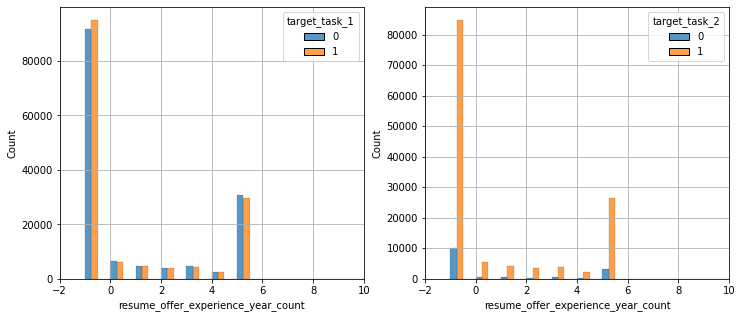

In [95]:
plotter_2cols(
    ["resume_offer_experience_year_count"], figsize=(12, 5), binwidth=0.5, xlim=(-2, 10)
)

По гистограмме хорошо видно, что пользователи как правило не указывают стаж.
В случае, если указывают - чаще встречается значение более 5 лет.
То есть то значение, которым можно гордиться.

Аналогичным образом проанализируем требуемый стаж работы в вакансиях.

In [96]:
df["vacancy_offer_experience_year_count"].unique()

array([-100.,    0.,    1.,    2.,   -1.,    3.,   nan,   10.,    5.,
          7.,    4.,    8.,    6.,    9.])

In [97]:
df["vacancy_offer_experience_year_count"].value_counts()

-100.0    113473
 1.0       59523
 3.0       29106
-1.0       28009
 2.0       14811
 0.0       13099
 5.0        9334
 4.0         898
 10.0        594
 6.0         438
 7.0         320
 8.0          92
 9.0          28
Name: vacancy_offer_experience_year_count, dtype: int64

В этом признаке неожиданные значения `-100` и `-1`.
Обработаем их аналогичным образом.

In [98]:
df.loc[
    df["vacancy_offer_experience_year_count"] < -1,
    "vacancy_offer_experience_year_count",
] = -1

df["vacancy_offer_experience_year_count"] = df[
    "vacancy_offer_experience_year_count"
].fillna(-1)

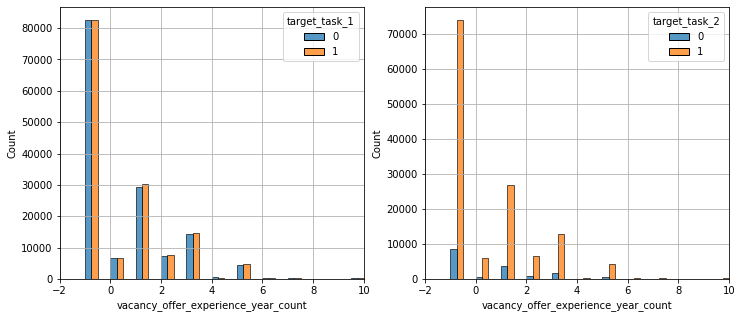

In [99]:
plotter_2cols(
    ["vacancy_offer_experience_year_count"],
    figsize=(12, 5),
    binwidth=0.5,
    xlim=(-2, 10),
)

Аналогично соискателям, работодатели чаще всего не указывают требуемый опыт.
Однако, в противопоставлении соискателям, если указывают, то чаще ищут специалистов со стажем 1 год.
Такое поведение позволяет не спугнуть талантливых выпускников ВУЗов или соискателей, которые меняют профессию.

Построим гистограмму со стажем в вакансии и его категорией. 

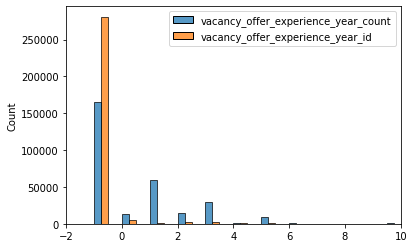

In [100]:
plt.xlim(-2, 10)
sns.histplot(
    data=df[
        ["vacancy_offer_experience_year_count", "vacancy_offer_experience_year_id"]
    ],
    binwidth=0.5,
    multiple="dodge",
)
plt.show()

Очевидно, что графики не соответствуют друг другу.
Почему так происходит - не понятно. 
Предположительно, категория должна автоматически выставляться на основании информации о стаже. 
Возможно, признак `vacancy_offer_experience_year_count` истолкован неправильно.
К сожалению, Анастасия ушла от ответа, что означает этот признак.

## Текстовые признаки

Последняя группа признаков, требующих анализа - текстовые.

### Должность в резюме

Посмотрим на значения в признаке с должностью в резюме.

In [101]:
df["resume_position"].value_counts().head(10)

Водитель                6918
водитель                5904
Менеджер по продажам    5796
Администратор           5392
Продавец                4706
Продавец-консультант    4544
Охранник                4543
Продавец-кассир         4347
продавец                4296
Бухгалтер               4088
Name: resume_position, dtype: int64

In [102]:
df["resume_position"].sort_values().tail(20)

62661                      юрист удаленно
99418                юрист, Ведущий юрист
94371                юрист, Ведущий юрист
23117                юрист, администратор
94331     юрист, менеджер по обслуживанию
292618        юрист, менеджер по продажам
116716                   юрист, начальник
19114                    юрист, начальник
106125             юрист, помощник юриста
283627                 юрист, регистратор
77064                  юрист, регистратор
169105                 юрист, регистратор
85193       юрист, специалист по закупкам
68797                      юрист, учитель
152239                                 —-
269771                                 —-
110491                                  👀
267462                                  👍
107060                                  👍
39413                                 🤠🤨🤨
Name: resume_position, dtype: object

In [103]:
df["resume_position"].sort_values().head(300)

210049                                               !
41663                                                !
267808                                               !
181184                                             """
80047                                          (Вахта)
                              ...                     
248501                                   Call менеджер
169531                                              Ch
100357    Chief Information Officer (CIO)/ Директор ИТ
106245                                      Coll centr
55187                                    Cool мэнеджер
Name: resume_position, Length: 300, dtype: object

Признак содержит русские и английские слова, знаки пунктуации и даже смайлики.
Для дальнейшей работы необходимо оставить только один язык, а также провести очистку содержимого от знаков пунктуации. 
Также очистим датасет от стопслов и приведем все к нижнему регистру.

In [104]:
stopwords_rus = set(nltk_stopwords.words("russian"))

In [105]:
def clear(row, feature):
    # Регистр
    text = row[feature].lower()
    # HTML-tags
    text = " ".join(re.sub(r"<[^>]+>", "", text, flags=re.S).split())
    text = " ".join(re.sub(r"&[a-z]+;", "", text, flags=re.S).split())
    # Пунктуация и служебные символы
    text = " ".join(re.sub(r"[^а-яё ]", " ", text).split())
    # Стоп-слова
    text = " ".join([w for w in word_tokenize(text) if not w in stopwords_rus])
    return text

In [106]:
%%time
feature = 'resume_position'
df['resume_position_clear'] = df.apply(clear, args=[feature], axis=1)

Wall time: 42.3 s


Следующим шагом проведем стемминг слов для группировки одинаковых с различными окончаниями.

In [107]:
stem_rus = SnowballStemmer("russian")
stem_eng = SnowballStemmer("english")

In [108]:
def stemmer(row, feature):
    text = row[feature]
    try:
        text = " ".join([stem_rus.stem(word) for word in text.split()])
        text = " ".join([stem_eng.stem(word) for word in text.split()])
    except:
        text = np.NaN
    return text

In [109]:
def stemmer_batch(feature, batch_size):
    feature_name = feature + "_stem"
    df[feature_name] = np.NaN
    for i in tqdm(range(df.shape[0] // batch_size)):
        df.loc[batch_size * i : batch_size * (i + 1), feature_name] = df[
            batch_size * i : batch_size * (i + 1)
        ].apply(stemmer, args=([feature]), axis=1)

    df.loc[batch_size * (i + 1) :, feature_name] = df[batch_size * (i + 1) :].apply(
        stemmer, args=([feature]), axis=1
    )

In [110]:
df = df.reset_index(drop=True)

In [111]:
stemmer_batch("resume_position_clear", 10000)

  0%|          | 0/29 [00:00<?, ?it/s]

Проверим количество неудачных объектов при обработке и ее качество.

In [112]:
df["resume_position_clear_stem"].isna().sum()

0

In [113]:
df[
    ["resume_position", "resume_position_clear", "resume_position_clear_stem"]
].sort_values(by="resume_position_clear_stem", ascending=True)

,resume_position,resume_position_clear,resume_position_clear_stem
25721,-,,
191031,Shunkov-miha@mail.ru,,
39397,🤠🤨🤨,,
47261,Junior Data scientist,,
177453,katrin4ik1996@mail.ru,,
...,...,...,...
42540,"Юрист, юрисконсульт (удаленно)",юрист юрисконсульт удаленно,юрист юрисконсульт удален
229521,Юрт,юрт,юрт
229268,Юутужник,юутужник,юутужник
69161,Юутуку,юутуку,юутук


В результате обработки могли появиться пустые строки в столбце.
Определим их количество.

In [114]:
df[df["resume_position_clear_stem"] == ""]["resume_position_clear_stem"].count()

498

Количество объектов около 0,1% от общей длины датасета, а значит, они могут быть исключены.

In [115]:
df = df.drop(df[df["resume_position_clear_stem"] == ""].index)

Проверим изменение распределений значений в столбце и определим количество откликов по каждой вакансии.

In [116]:
df.groupby(by="resume_position_clear_stem")["target_task_1"].agg(
    {"sum", "count"}
).sort_values(by="sum", ascending=False).head(20)

,sum,count
resume_position_clear_stem,,
водител,6641,12901
продавец,4667,9005
администратор,3631,7087
курьер,3566,6863
охранник,3455,6999
менеджер продаж,3086,6579
бухгалтер,2486,4869
продавец консультант,2432,4986
продавец кассир,2418,4862


В результате обработки водителей и продавцов стало в 2 раза больше. 
При этом, распределение целевого признака 50/50 сохраняется.

Признак содержит длинные тексты. 
Создадим соответствующий признак, который может быть значимым при моделировании, и посмотри его распределение. 

### Должность в вакансии

Проведем аналогичную обработку признака должности в вакансии.

In [117]:
%%time
feature = 'vacancy_custom_position'
df['vacancy_custom_position_clear'] = df.apply(clear, args=[feature], axis=1)

Wall time: 46 s


In [118]:
df = df.reset_index(drop=True)
stemmer_batch("vacancy_custom_position_clear", 10000)

  0%|          | 0/29 [00:00<?, ?it/s]

In [119]:
df["vacancy_custom_position_clear_stem"].isna().sum()

0

In [120]:
df[df["vacancy_custom_position_clear_stem"] == ""][
    "vacancy_custom_position_clear_stem"
].count()

143

In [121]:
df[
    [
        "vacancy_custom_position",
        "vacancy_custom_position_clear",
        "vacancy_custom_position_clear_stem",
    ]
].sort_values(by="vacancy_custom_position_clear_stem", ascending=True)

,vacancy_custom_position,vacancy_custom_position_clear,vacancy_custom_position_clear_stem
21127,Demo teacher,,
163202,Product manager,,
156005,Middle QA engineer,,
129038,Demo Teacher,,
63967,Middle QA engineer,,
...,...,...,...
184334,Юрист/юрист первичного приема,юрист юрист первичного приема,юрист юрист первичн прием
109332,Юрист/юрист первичного приема,юрист юрист первичного приема,юрист юрист первичн прием
151997,Юрист/юрист первичного приема,юрист юрист первичного приема,юрист юрист первичн прием
226021,Юрист/юрист первичного приема,юрист юрист первичного приема,юрист юрист первичн прием


In [122]:
df = df.drop(df[df["vacancy_custom_position_clear_stem"] == ""].index)

In [123]:
df.groupby(by="vacancy_custom_position_clear_stem")["target_task_1"].agg(
    {"sum", "count"}
).sort_values(by="sum", ascending=False).head(20)

,sum,count
vacancy_custom_position_clear_stem,,
менеджер продаж,2921,6362
продавец кассир,2821,5491
продавец консультант,2716,5474
охранник,2409,4809
оператор центр,2334,4614
курьер,1725,3210
грузчик,1568,3118
бухгалтер,1350,2622
водител экспедитор,1223,2409


Самые популярные вакансии - менеджер по продажам и продавец-кассир.

### Описание вакансии

Проведем аналогичную обработку признака с описанием вакансии.

!!! Обработка занимает около 40 минут !!!

In [124]:
%%time
df['vacancy_description_clear'] = df.apply(
    clear, args=['vacancy_description'], axis=1)

Wall time: 4min 19s


In [125]:
df = df.reset_index(drop=True)
stemmer_batch("vacancy_description_clear", 10000)

  0%|          | 0/29 [00:00<?, ?it/s]

In [126]:
df["vacancy_description_clear_stem"].isna().sum()

0

In [127]:
df[df["vacancy_description_clear_stem"] == ""]["vacancy_description_clear_stem"].count()

43

In [128]:
df[
    [
        "vacancy_description",
        "vacancy_description_clear",
        "vacancy_description_clear_stem",
    ]
].sort_values(by="vacancy_description_clear_stem", ascending=True).head(20)

,vacancy_description,vacancy_description_clear,vacancy_description_clear_stem
272959,&nbsp;<br />\r\n\r\n\r\n<br />,,
274545,<strong><strong>Applicants are considered for ...,,
121026,<strong><strong>Applicants are considered for ...,,
20132,<br /> <strong><strong>Applicants are consider...,,
62556,Online school Foxford is looking for a motivat...,,
251610,<br /> <strong><strong>Applicants are consider...,,
253924,&nbsp;<br />\r\n\r\n\r\n<br />,,
230094,<strong><strong>Applicants are considered for ...,,
242120,<strong>Sorumluluklar:</strong><br />\r\n<ul>\...,,
102448,<br /> <strong><strong>Applicants are consider...,,


In [129]:
df = df.drop(df[df["vacancy_description_clear_stem"] == ""].index)

Минимально описание вакансии включает всего 2 слова.
В то время, как наибольшее содержит более 600. 
Это окажется важным, если использовать для формирования эмбедингов при помощи моделей типа BERT, которые обучены на корпусах длиной 512 слов.

### Комментарии к расписанию в вакансии

Учитывая, что в последнем текстовом признаке большое количество пропусков, проведем визуальный анализ объектов, для которых значение не пропущено. 

In [130]:
df[df["vacancy_operating_schedule_comment"].notna()]

,resume_id,vacancy_id,birth_date,resume_position,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_custom_position,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_description,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_operating_schedule_comment,vacancy_offer_experience_year_id,target_task_1,target_task_2,resume_position_clear,resume_position_clear_stem,vacancy_custom_position_clear,vacancy_custom_position_clear_stem,vacancy_description_clear,vacancy_description_clear_stem
276,23899799,42677868,1998.0,Эколог,30000.0,1,False,False,4,False,True,87.0,-1.0,3,Инженер по охране окружающей среды,1,25000,30000.0,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,4,1.0,936386,False,1,5/2,-1,0,1,эколог,эколог,инженер охране окружающей среды,инженер охран окружа сред,обязанности контроль соблюдением действующего ...,обязан контрол соблюден действ экологическ зак...
334,27506403,42816112,1971.0,Водитель,50000.0,1,False,True,2,False,False,85.0,-1.0,1257,Водитель экспедитор,1,50000,80000.0,<strong>Крупнейший интернет- магазин России на...,0,0.0,1507711,True,57,так же есть вахта,-1,0,1,водитель,водител,водитель экспедитор,водител экспедитор,крупнейший интернет магазин россии набирает ко...,крупн интернет магазин росс набира команд води...
457,28364019,43732656,1975.0,Продавец-кассир,25000.0,1,False,False,1,False,True,85.0,5.0,240,Комплектовщик,3,30000,-1.0,<strong>Требования:</strong><br /> &middot; от...,0,0.0,758795,False,9,2/2,-1,0,1,продавец кассир,продавец кассир,комплектовщик,комплектовщик,требования ответственность внимательность опыт...,требован ответствен внимательн оп работ склад ...
1096,22146088,32944749,1994.0,Менеджер по продажам,35000.0,57,False,False,1,False,True,83.0,-1.0,193,Консультант по банковским продуктам,1,50000,100000.0,<ul>\r\n<li>\r\n<strong>Мы создаем новый финан...,0,-1.0,1730706,False,1,"сменный, частичный",-1,0,1,менеджер продажам,менеджер продаж,консультант банковским продуктам,консультант банковск продукт,создаем новый финансовый продукт которым будут...,созда нов финансов продукт котор будут пользов...
1287,25971581,40979763,1981.0,Охранник без лицензии,40000.0,1,False,False,2,False,True,87.0,4.0,3,Охранники,7,36000,50000.0,Требуются на объекты в Москве и Московской обл...,0,-1.0,909469,False,1,"от 15 дней, проживание на объекте",-1,0,1,охранник лицензии,охранник лиценз,охранники,охранник,требуются объекты москве московской области оп...,треб объект москв московск област опыт работ п...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291173,29515181,40672598,2001.0,Комплектовщица,-1.0,1,False,False,3,False,False,75.0,-1.0,3,Комплектовщик в интернет-магазин,3,30000,-1.0,"<strong>Сеть гипермаркетов ""Твой Дом"" проводит...",0,-1.0,1446229,False,1,2/2,-1,1,1,комплектовщица,комплектовщиц,комплектовщик интернет магазин,комплектовщик интернет магазин,сеть гипермаркетов твой дом проводит набор сот...,сет гипермаркет тво дом провод набор сотрудник...
291227,28584520,40266108,1963.0,"Начальник смены, охранник, водитель кат. ВС",60000.0,2,False,True,4,False,False,85.0,-1.0,4,Инженер по обслуживанию оборудования,1,56000,-1.0,<strong>Кадровая компания &laquo;Рекадро&raquo...,0,3.0,32428,True,2,неделя в утро\неделя в вечер\неделя в ночь,-1,1,1,начальник смены охранник водитель кат вс,начальник смен охранник водител кат вс,инженер обслуживанию оборудования,инженер обслуживан оборудован,кадровая компания рекадро совместно иностранно...,кадров компан рекадр совместн иностра компан п...
291393,28937539,41245659,1984.0,Администратор,-1.0,1,False,False,4,False,False,77.0,-1.0,3,Инженер по охране окружающей среды,1,25000,30000.0,<strong>Обязанн

In [131]:
df[df["vacancy_operating_schedule_comment"].notna()][
    "vacancy_operating_schedule_comment"
].count() / len(df)

0.004944726365609035

Объекты, для которых значение не пропущено, не несут большой смысловой нагрузки.
Учитывая, что их количество не превосходит 0,5% от общего объема датасета, представляется целесообразным удалить целиком признак из рассмотрения.

Одновременно удалим промежуточные признаки, полученные при обработке текстов.

In [132]:
df = df.drop(
    [
        "vacancy_operating_schedule_comment",
        "resume_position",
        "resume_position_clear",
        "vacancy_custom_position",
        "vacancy_custom_position_clear",
        "vacancy_description",
        "vacancy_description_clear",
    ],
    axis=1,
)

In [133]:
text_features = [
    "resume_position_clear_stem",
    "vacancy_custom_position_clear_stem",
    "vacancy_description_clear_stem",
]

## Phik

На завершающей стадии EDA посмотрим корреляцию между признаками при помощи модуля phik, который определяет и нелинейную зависимость.

In [134]:
phik = df.drop(text_features, axis=1).phik_matrix()

interval columns not set, guessing: ['resume_id', 'vacancy_id', 'birth_date', 'resume_salary_from', 'resume_city_id', 'resume_offer_education_id', 'percentage_of_resume_completion', 'resume_offer_experience_year_count', 'resume_region_id', 'vacancy_operating_schedule_id', 'vacancy_salary_from', 'vacancy_salary_to', 'vacancy_offer_education_id', 'vacancy_offer_experience_year_count', 'vacany_company_id', 'vacancy_city_id', 'vacancy_offer_experience_year_id', 'target_task_1', 'target_task_2']


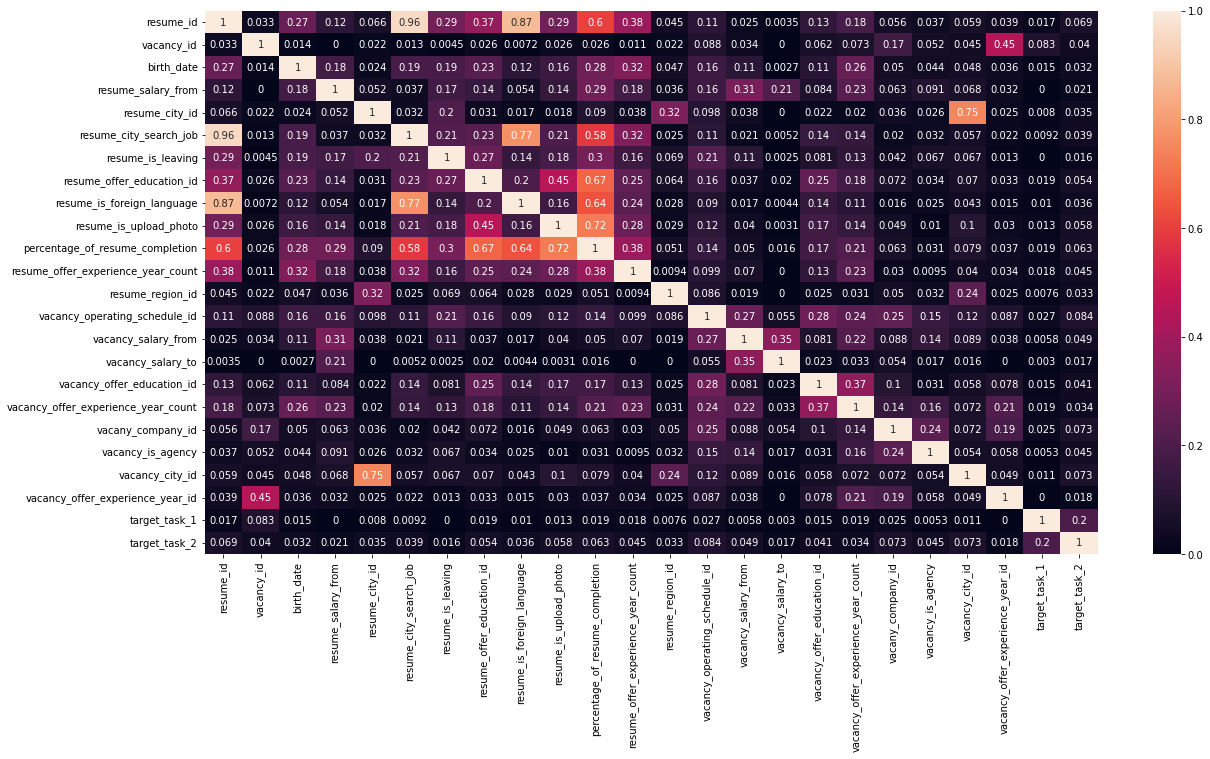

In [135]:
plt.figure(figsize=(20, 10))
sns.heatmap(phik, annot=True)
plt.show()

По построенной карте видно, что по целевым признакам ни один из признаков не выделяется как сильно влияющий. 
Максимальное значение коэффициента корреляции для них не превосходит 0,15 (не учитывая корреяляцию между самими целевыми признаками).
Полученный результат не позволяет использовать признаки для формирования аналитических зависимостей, которые можно использовать в качестве baseline.

Кроме того, наблюдается мультиколлинеарность между некоторыми признаками, которая, во-первых, ограничивает применение линейных алгоритмов и вносит дополнительный шум в данные.
Так коллинеарность пары признаков `resume_id` и `resume_foreign_language` представляется необъяснимой, а значит, может быть признана случайным совпадением чисел.
В то же время коллинеарность признака заполненности профиля соискателя с другими персональными данными представляется осуществимой.

# Заключение по EDA

In [136]:
len(df) / lenght_init

0.9817594406720523

В результате EDA проанализированы признаки в датасете согласно намеченному плану. 
Проведена обработка данных, исправлены типы хранения данных, удалены неявные дубликаты, пропуски и выбросы, после чего размер датасета сократился менее, чем на 2% объектов и один признак.
Указанные значения не должны оказать влияния на последующее моделирование.

Датасет содержит данные для решения двух задач.
При этом вторая задача решается только для объектов, имеющих положительное значение в поле целевого признака первой задачи.
Указанный факт необходимо использовать при построении моделей машинного обучения.

Рассмотрение признаков со значениями ID регионов и городов позволяет сделать вывод, что настоящий датасет относится к одному региону / области / округу, но не к целой стране целиком.

При указании уровня образования соискателя стремятся указать действительное образование, в то время как работодатели в резюме указывают "стандартные" значения. К последним относятся одно из следующих: отсутствие образования, среднее, средне-специальное, неоконченное высшее, высшее.

Анализ данных показал, что датасет, скорее всего, специально стратифицирован по всем признакам.
Это проявляется в том, что по всем признакам распределение целевых признаков практически не изменяется и находится на уровне 50/50 для первой задачи и 90/10 - для второй.
Такой вывод подтверждает анализ коэффициентов корреляции целевых признаков с остальными, в результате которого получено, что значения коэффициентов не превосходят 0,15.
В этой связи можно предположить, что на целевые признаки в большей степени влияют текстовые признаки. Однако для учета такого влияния требуется обучение нейронных сетей, что в действующие временные рамки представляется нецелесообразным.

Сохраним полученный датасет в отдельный файл для последующего фич-инжиниринга.

In [137]:
df.to_csv("vacancy_resume_data_eda.csv", index=False)